# Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2  
%autosave 10

Autosaving every 10 seconds


In [2]:
import torch, torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
from PIL import Image
import random, os, sys, argparse
from pathlib import Path
from tqdm import tqdm
import pickle

from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import shap

In [3]:

from models import *

# User Hyperparams

In [4]:
model = 'resnet18' 
dataset = 'cow_vs_birds_balanced'
num_classes = 2  
expt_name = f'{model}_{dataset}_{int(random.random()*100000)}'
save_dir = 'xxx'

num_epochs = 500
lr = 0.01
seed = 0
num_ch = 3 # num of channels in image
num_embs = 2000 # 1500 for mnist, 10k for cifar10
K = 29 # K neighbours
num_test_imgs = 100 # num of test images for plotting PD
lp_norm = 1 # for computing KNN
knn_pos_thresh = 0.5
knn_neg_thresh = 0.5

# Util Functions

In [5]:
# takes in a list of img paths and plots grid of images
def plot_images(img_list, rows, cols, titles=None):
    plt.figure(figsize=(7.5*cols,7.5*rows))
    for i in range(rows*cols):
        plt.subplot(rows,cols,i+1)
        if type(img_list[0])==str:
            img = plt.imread(img_list[i])
        else:
            img = img_list[i]
        plt.imshow(img)
        if titles is not None:
            plt.title(titles[i])
    plt.show()
    
class center_crop(object):
    def crop_center(self, img):
        _, y, x = img.shape
        crop_size = np.min([y,x])
        startx = x // 2 - (crop_size // 2)
        starty = y // 2 - (crop_size // 2)
        return img[:, starty:starty + crop_size, startx:startx + crop_size]
    
    def __call__(self, img):
        return self.crop_center(img)

# Load Dataset

In [6]:
# Setting the seed
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [7]:
# datasets
print('==> Preparing data..')
if dataset=='cow_vs_birds_spurious':
    # transformations
    trans = torchvision.transforms.Compose([
                torchvision.transforms.Resize((224,224)),
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Lambda(center_crop()),
            ])  

    
    trainset = torchvision.datasets.ImageFolder(root=f'{root_dir}/train/',transform=trans)
    testset = torchvision.datasets.ImageFolder(root=f'{root_dir}/test/',transform=trans)
    test_pd_set = torchvision.datasets.ImageFolder(root=f'{root_dir}/test_pd/',transform=trans)
    
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=4)
    testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=4)
elif dataset=='cow_vs_birds_balanced':
    # transformations
    trans = torchvision.transforms.Compose([
                torchvision.transforms.Resize((224,224)),
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Lambda(center_crop()),
            ])  

    root_dir = 'xxx'
    trainset = torchvision.datasets.ImageFolder(root=f'{root_dir}/train/',transform=trans)
    testset = torchvision.datasets.ImageFolder(root=f'xxx',transform=trans)
    
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=4)
    testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=4)

==> Preparing data..


In [8]:
# for batch_idx, (inputs, targets) in enumerate(tqdm(trainloader)):
#     break
    

# Train Model

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy


# Model
print('==> Building model..')
if model=='resnet18':
    # net = VGG('VGG19')
    net = ResNet18(num_channels=num_ch,num_classes=num_classes)
    # net = PreActResNet18()
    # net = GoogLeNet()
    # net = DenseNet121()
    # net = ResNeXt29_2x64d()
    # net = MobileNet()
    # net = MobileNetV2()
    # net = DPN92()
    # net = ShuffleNetG2()
    # net = SENet18()
    # net = ShuffleNetV2(1)
    # net = EfficientNetB0()
    # net = RegNetX_200MF()
    # net = SimpleDLA()
elif model=='vgg16':
    net = VGG('VGG16',num_channels=num_ch)
elif model=='densenet121':
    net = DenseNet121()
net = net.to(device)
    
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)


# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(tqdm(trainloader)):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    print(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                 % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))


def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(tqdm(testloader)):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    print(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                 % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
#         if not os.path.isdir(f'{args['expt_name']}_checkpoint'):
#             os.mkdir('checkpoint')
        torch.save(state, os.path.join(save_dir,f'{expt_name}.pt'))
        best_acc = acc


for epoch in range(num_epochs):
    train(epoch)
    test(epoch)
    scheduler.step()

==> Building model..

Epoch: 0


100%|██████████| 8/8 [00:30<00:00,  3.85s/it]


7 8 Loss: 22.120 | Acc: 53.539% (537/1003)


100%|██████████| 3/3 [00:03<00:00,  1.24s/it]


2 3 Loss: 48501.778 | Acc: 46.386% (154/332)
Saving..

Epoch: 1


100%|██████████| 8/8 [00:12<00:00,  1.58s/it]


7 8 Loss: 10.264 | Acc: 46.959% (471/1003)


100%|██████████| 3/3 [00:02<00:00,  1.24it/s]


2 3 Loss: 2291.314 | Acc: 49.699% (165/332)
Saving..

Epoch: 2


100%|██████████| 8/8 [00:12<00:00,  1.58s/it]


7 8 Loss: 3.894 | Acc: 51.944% (521/1003)


100%|██████████| 3/3 [00:02<00:00,  1.25it/s]


2 3 Loss: 954.518 | Acc: 52.108% (173/332)
Saving..

Epoch: 3


100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


7 8 Loss: 2.501 | Acc: 55.633% (558/1003)


100%|██████████| 3/3 [00:02<00:00,  1.24it/s]


2 3 Loss: 23.427 | Acc: 50.904% (169/332)

Epoch: 4


100%|██████████| 8/8 [00:12<00:00,  1.61s/it]


7 8 Loss: 2.091 | Acc: 54.636% (548/1003)


100%|██████████| 3/3 [00:02<00:00,  1.30it/s]


2 3 Loss: 9.328 | Acc: 56.024% (186/332)
Saving..

Epoch: 5


100%|██████████| 8/8 [00:12<00:00,  1.60s/it]


7 8 Loss: 1.660 | Acc: 57.129% (573/1003)


100%|██████████| 3/3 [00:02<00:00,  1.26it/s]


2 3 Loss: 2.402 | Acc: 57.229% (190/332)
Saving..

Epoch: 6


100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


7 8 Loss: 1.734 | Acc: 56.530% (567/1003)


100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


2 3 Loss: 47.583 | Acc: 57.530% (191/332)
Saving..

Epoch: 7


100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


7 8 Loss: 1.353 | Acc: 63.509% (637/1003)


100%|██████████| 3/3 [00:02<00:00,  1.25it/s]


2 3 Loss: 9.855 | Acc: 54.819% (182/332)

Epoch: 8


100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


7 8 Loss: 1.415 | Acc: 60.718% (609/1003)


100%|██████████| 3/3 [00:02<00:00,  1.24it/s]


2 3 Loss: 0.956 | Acc: 60.241% (200/332)
Saving..

Epoch: 9


100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


7 8 Loss: 1.600 | Acc: 64.108% (643/1003)


100%|██████████| 3/3 [00:02<00:00,  1.25it/s]


2 3 Loss: 0.681 | Acc: 54.518% (181/332)

Epoch: 10


100%|██████████| 8/8 [00:12<00:00,  1.60s/it]


7 8 Loss: 1.186 | Acc: 54.437% (546/1003)


100%|██████████| 3/3 [00:02<00:00,  1.23it/s]


2 3 Loss: 46.372 | Acc: 57.229% (190/332)

Epoch: 11


100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


7 8 Loss: 1.789 | Acc: 60.718% (609/1003)


100%|██████████| 3/3 [00:02<00:00,  1.24it/s]


2 3 Loss: 13.036 | Acc: 57.831% (192/332)

Epoch: 12


100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


7 8 Loss: 1.649 | Acc: 59.123% (593/1003)


100%|██████████| 3/3 [00:02<00:00,  1.25it/s]


2 3 Loss: 1.557 | Acc: 52.108% (173/332)

Epoch: 13


100%|██████████| 8/8 [00:12<00:00,  1.58s/it]


7 8 Loss: 1.100 | Acc: 62.512% (627/1003)


100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


2 3 Loss: 0.970 | Acc: 49.699% (165/332)

Epoch: 14


100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


7 8 Loss: 1.706 | Acc: 61.216% (614/1003)


100%|██████████| 3/3 [00:02<00:00,  1.26it/s]


2 3 Loss: 1.009 | Acc: 59.940% (199/332)

Epoch: 15


100%|██████████| 8/8 [00:12<00:00,  1.58s/it]


7 8 Loss: 1.024 | Acc: 61.416% (616/1003)


100%|██████████| 3/3 [00:02<00:00,  1.24it/s]


2 3 Loss: 0.884 | Acc: 55.120% (183/332)

Epoch: 16


100%|██████████| 8/8 [00:12<00:00,  1.60s/it]


7 8 Loss: 0.824 | Acc: 57.428% (576/1003)


100%|██████████| 3/3 [00:02<00:00,  1.26it/s]


2 3 Loss: 0.917 | Acc: 53.916% (179/332)

Epoch: 17


100%|██████████| 8/8 [00:12<00:00,  1.58s/it]


7 8 Loss: 1.048 | Acc: 64.307% (645/1003)


100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


2 3 Loss: 0.807 | Acc: 56.024% (186/332)

Epoch: 18


100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


7 8 Loss: 0.645 | Acc: 67.697% (679/1003)


100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


2 3 Loss: 0.695 | Acc: 58.735% (195/332)

Epoch: 19


100%|██████████| 8/8 [00:12<00:00,  1.58s/it]


7 8 Loss: 1.174 | Acc: 65.803% (660/1003)


100%|██████████| 3/3 [00:02<00:00,  1.26it/s]


2 3 Loss: 0.704 | Acc: 61.446% (204/332)
Saving..

Epoch: 20


100%|██████████| 8/8 [00:12<00:00,  1.58s/it]


7 8 Loss: 0.911 | Acc: 67.896% (681/1003)


100%|██████████| 3/3 [00:02<00:00,  1.26it/s]


2 3 Loss: 0.705 | Acc: 59.639% (198/332)

Epoch: 21


100%|██████████| 8/8 [00:12<00:00,  1.60s/it]


7 8 Loss: 0.701 | Acc: 70.788% (710/1003)


100%|██████████| 3/3 [00:02<00:00,  1.24it/s]


2 3 Loss: 1.041 | Acc: 60.843% (202/332)

Epoch: 22


100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


7 8 Loss: 0.680 | Acc: 73.081% (733/1003)


100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


2 3 Loss: 1.067 | Acc: 60.843% (202/332)

Epoch: 23


100%|██████████| 8/8 [00:12<00:00,  1.60s/it]


7 8 Loss: 0.860 | Acc: 70.289% (705/1003)


100%|██████████| 3/3 [00:02<00:00,  1.23it/s]


2 3 Loss: 0.872 | Acc: 61.446% (204/332)

Epoch: 24


100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


7 8 Loss: 0.578 | Acc: 72.682% (729/1003)


100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


2 3 Loss: 0.860 | Acc: 61.145% (203/332)

Epoch: 25


100%|██████████| 8/8 [00:12<00:00,  1.61s/it]


7 8 Loss: 0.651 | Acc: 70.389% (706/1003)


100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


2 3 Loss: 0.720 | Acc: 62.048% (206/332)
Saving..

Epoch: 26


100%|██████████| 8/8 [00:12<00:00,  1.60s/it]


7 8 Loss: 0.659 | Acc: 72.283% (725/1003)


100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


2 3 Loss: 1.981 | Acc: 57.229% (190/332)

Epoch: 27


100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


7 8 Loss: 0.701 | Acc: 70.688% (709/1003)


100%|██████████| 3/3 [00:02<00:00,  1.26it/s]


2 3 Loss: 2.476 | Acc: 62.048% (206/332)

Epoch: 28


100%|██████████| 8/8 [00:12<00:00,  1.58s/it]


7 8 Loss: 1.449 | Acc: 72.682% (729/1003)


100%|██████████| 3/3 [00:02<00:00,  1.17it/s]


2 3 Loss: 0.841 | Acc: 63.253% (210/332)
Saving..

Epoch: 29


100%|██████████| 8/8 [00:12<00:00,  1.58s/it]


7 8 Loss: 1.072 | Acc: 67.398% (676/1003)


100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


2 3 Loss: 28.735 | Acc: 59.940% (199/332)

Epoch: 30


100%|██████████| 8/8 [00:12<00:00,  1.58s/it]


7 8 Loss: 1.288 | Acc: 67.597% (678/1003)


100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


2 3 Loss: 5.012 | Acc: 62.952% (209/332)

Epoch: 31


100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


7 8 Loss: 0.851 | Acc: 71.884% (721/1003)


100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


2 3 Loss: 1.717 | Acc: 56.627% (188/332)

Epoch: 32


100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


7 8 Loss: 1.736 | Acc: 68.594% (688/1003)


100%|██████████| 3/3 [00:02<00:00,  1.31it/s]


2 3 Loss: 1.857 | Acc: 60.843% (202/332)

Epoch: 33


100%|██████████| 8/8 [00:12<00:00,  1.60s/it]


7 8 Loss: 1.389 | Acc: 65.703% (659/1003)


100%|██████████| 3/3 [00:02<00:00,  1.25it/s]


2 3 Loss: 0.757 | Acc: 63.855% (212/332)
Saving..

Epoch: 34


100%|██████████| 8/8 [00:12<00:00,  1.60s/it]


7 8 Loss: 1.371 | Acc: 63.609% (638/1003)


100%|██████████| 3/3 [00:02<00:00,  1.25it/s]


2 3 Loss: 1.068 | Acc: 56.325% (187/332)

Epoch: 35


100%|██████████| 8/8 [00:12<00:00,  1.62s/it]


7 8 Loss: 1.017 | Acc: 69.492% (697/1003)


100%|██████████| 3/3 [00:02<00:00,  1.20it/s]


2 3 Loss: 0.930 | Acc: 59.639% (198/332)

Epoch: 36


100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


7 8 Loss: 0.869 | Acc: 72.084% (723/1003)


100%|██████████| 3/3 [00:02<00:00,  1.24it/s]


2 3 Loss: 0.794 | Acc: 54.819% (182/332)

Epoch: 37


100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


7 8 Loss: 0.606 | Acc: 71.984% (722/1003)


100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


2 3 Loss: 0.665 | Acc: 60.241% (200/332)

Epoch: 38


100%|██████████| 8/8 [00:12<00:00,  1.58s/it]


7 8 Loss: 0.791 | Acc: 75.274% (755/1003)


100%|██████████| 3/3 [00:02<00:00,  1.26it/s]


2 3 Loss: 0.669 | Acc: 62.651% (208/332)

Epoch: 39


100%|██████████| 8/8 [00:12<00:00,  1.58s/it]


7 8 Loss: 0.821 | Acc: 75.274% (755/1003)


100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


2 3 Loss: 0.669 | Acc: 61.145% (203/332)

Epoch: 40


100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


7 8 Loss: 0.562 | Acc: 75.872% (761/1003)


100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


2 3 Loss: 0.670 | Acc: 63.554% (211/332)

Epoch: 41


100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


7 8 Loss: 0.561 | Acc: 76.471% (767/1003)


100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


2 3 Loss: 0.654 | Acc: 65.663% (218/332)
Saving..

Epoch: 42


100%|██████████| 8/8 [00:12<00:00,  1.58s/it]


7 8 Loss: 0.482 | Acc: 78.066% (783/1003)


100%|██████████| 3/3 [00:02<00:00,  1.30it/s]


2 3 Loss: 0.664 | Acc: 65.361% (217/332)

Epoch: 43


100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


7 8 Loss: 0.483 | Acc: 78.066% (783/1003)


100%|██████████| 3/3 [00:02<00:00,  1.32it/s]


2 3 Loss: 0.666 | Acc: 66.566% (221/332)
Saving..

Epoch: 44


100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


7 8 Loss: 0.601 | Acc: 77.667% (779/1003)


100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


2 3 Loss: 0.615 | Acc: 65.060% (216/332)

Epoch: 45


100%|██████████| 8/8 [00:12<00:00,  1.58s/it]


7 8 Loss: 0.473 | Acc: 79.960% (802/1003)


100%|██████████| 3/3 [00:02<00:00,  1.26it/s]


2 3 Loss: 0.605 | Acc: 67.470% (224/332)
Saving..

Epoch: 46


100%|██████████| 8/8 [00:12<00:00,  1.58s/it]


7 8 Loss: 0.466 | Acc: 81.157% (814/1003)


100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


2 3 Loss: 0.629 | Acc: 67.771% (225/332)
Saving..

Epoch: 47


100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


7 8 Loss: 0.459 | Acc: 79.960% (802/1003)


100%|██████████| 3/3 [00:02<00:00,  1.25it/s]


2 3 Loss: 0.604 | Acc: 68.373% (227/332)
Saving..

Epoch: 48


100%|██████████| 8/8 [00:12<00:00,  1.58s/it]


7 8 Loss: 0.413 | Acc: 80.259% (805/1003)


100%|██████████| 3/3 [00:02<00:00,  1.31it/s]


2 3 Loss: 0.595 | Acc: 66.867% (222/332)

Epoch: 49


100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


7 8 Loss: 0.406 | Acc: 82.054% (823/1003)


100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


2 3 Loss: 0.567 | Acc: 67.771% (225/332)

Epoch: 50


100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


7 8 Loss: 0.434 | Acc: 80.160% (804/1003)


100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


2 3 Loss: 0.593 | Acc: 68.072% (226/332)

Epoch: 51


100%|██████████| 8/8 [00:12<00:00,  1.58s/it]


7 8 Loss: 0.407 | Acc: 81.157% (814/1003)


100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


2 3 Loss: 0.579 | Acc: 68.072% (226/332)

Epoch: 52


100%|██████████| 8/8 [00:12<00:00,  1.58s/it]


7 8 Loss: 0.545 | Acc: 81.755% (820/1003)


100%|██████████| 3/3 [00:02<00:00,  1.25it/s]


2 3 Loss: 0.632 | Acc: 70.482% (234/332)
Saving..

Epoch: 53


100%|██████████| 8/8 [00:12<00:00,  1.60s/it]


7 8 Loss: 0.511 | Acc: 81.954% (822/1003)


100%|██████████| 3/3 [00:02<00:00,  1.31it/s]


2 3 Loss: 0.748 | Acc: 67.771% (225/332)

Epoch: 54


100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


7 8 Loss: 0.393 | Acc: 81.954% (822/1003)


100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


2 3 Loss: 0.667 | Acc: 66.265% (220/332)

Epoch: 55


100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


7 8 Loss: 0.463 | Acc: 80.359% (806/1003)


100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


2 3 Loss: 0.639 | Acc: 68.072% (226/332)

Epoch: 56


100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


7 8 Loss: 0.581 | Acc: 81.057% (813/1003)


100%|██████████| 3/3 [00:02<00:00,  1.31it/s]


2 3 Loss: 0.646 | Acc: 67.771% (225/332)

Epoch: 57


100%|██████████| 8/8 [00:12<00:00,  1.60s/it]


7 8 Loss: 0.504 | Acc: 80.658% (809/1003)


100%|██████████| 3/3 [00:02<00:00,  1.26it/s]


2 3 Loss: 0.658 | Acc: 67.169% (223/332)

Epoch: 58


100%|██████████| 8/8 [00:12<00:00,  1.58s/it]


7 8 Loss: 0.433 | Acc: 82.453% (827/1003)


100%|██████████| 3/3 [00:02<00:00,  1.26it/s]


2 3 Loss: 0.630 | Acc: 69.880% (232/332)

Epoch: 59


100%|██████████| 8/8 [00:12<00:00,  1.58s/it]


7 8 Loss: 0.498 | Acc: 83.450% (837/1003)


100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


2 3 Loss: 0.619 | Acc: 68.675% (228/332)

Epoch: 60


100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


7 8 Loss: 0.350 | Acc: 84.347% (846/1003)


100%|██████████| 3/3 [00:02<00:00,  1.33it/s]


2 3 Loss: 0.647 | Acc: 69.578% (231/332)

Epoch: 61


100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


7 8 Loss: 0.338 | Acc: 85.444% (857/1003)


100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


2 3 Loss: 0.604 | Acc: 69.277% (230/332)

Epoch: 62


100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


7 8 Loss: 0.357 | Acc: 84.447% (847/1003)


100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


2 3 Loss: 0.571 | Acc: 70.482% (234/332)

Epoch: 63


100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


7 8 Loss: 0.337 | Acc: 84.746% (850/1003)


100%|██████████| 3/3 [00:02<00:00,  1.26it/s]


2 3 Loss: 0.625 | Acc: 69.277% (230/332)

Epoch: 64


100%|██████████| 8/8 [00:12<00:00,  1.60s/it]


7 8 Loss: 0.314 | Acc: 86.441% (867/1003)


100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


2 3 Loss: 0.598 | Acc: 70.482% (234/332)

Epoch: 65


100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


7 8 Loss: 0.319 | Acc: 85.643% (859/1003)


100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


2 3 Loss: 0.565 | Acc: 72.289% (240/332)
Saving..

Epoch: 66


100%|██████████| 8/8 [00:12<00:00,  1.58s/it]


7 8 Loss: 0.441 | Acc: 83.948% (842/1003)


100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


2 3 Loss: 0.743 | Acc: 69.880% (232/332)

Epoch: 67


100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


7 8 Loss: 0.324 | Acc: 85.543% (858/1003)


100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


2 3 Loss: 0.681 | Acc: 68.072% (226/332)

Epoch: 68


100%|██████████| 8/8 [00:12<00:00,  1.60s/it]


7 8 Loss: 0.332 | Acc: 86.241% (865/1003)


100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


2 3 Loss: 0.560 | Acc: 72.892% (242/332)
Saving..

Epoch: 69


100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


7 8 Loss: 0.404 | Acc: 83.051% (833/1003)


100%|██████████| 3/3 [00:02<00:00,  1.31it/s]


2 3 Loss: 0.653 | Acc: 70.482% (234/332)

Epoch: 70


100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


7 8 Loss: 0.298 | Acc: 87.238% (875/1003)


100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


2 3 Loss: 0.578 | Acc: 74.398% (247/332)
Saving..

Epoch: 71


100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


7 8 Loss: 0.281 | Acc: 88.235% (885/1003)


100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


2 3 Loss: 0.648 | Acc: 71.084% (236/332)

Epoch: 72


100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


7 8 Loss: 0.324 | Acc: 87.039% (873/1003)


100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


2 3 Loss: 0.612 | Acc: 71.988% (239/332)

Epoch: 73


100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


7 8 Loss: 0.321 | Acc: 85.444% (857/1003)


100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


2 3 Loss: 0.576 | Acc: 73.193% (243/332)

Epoch: 74


100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


7 8 Loss: 0.301 | Acc: 87.836% (881/1003)


100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


2 3 Loss: 0.584 | Acc: 73.494% (244/332)

Epoch: 75


100%|██████████| 8/8 [00:12<00:00,  1.58s/it]


7 8 Loss: 0.291 | Acc: 86.441% (867/1003)


100%|██████████| 3/3 [00:02<00:00,  1.30it/s]


2 3 Loss: 0.594 | Acc: 73.494% (244/332)

Epoch: 76


100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


7 8 Loss: 0.258 | Acc: 89.033% (893/1003)


100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


2 3 Loss: 0.631 | Acc: 73.795% (245/332)

Epoch: 77


100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


7 8 Loss: 0.260 | Acc: 89.133% (894/1003)


100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


2 3 Loss: 0.583 | Acc: 73.795% (245/332)

Epoch: 78


100%|██████████| 8/8 [00:12<00:00,  1.58s/it]


7 8 Loss: 0.298 | Acc: 90.030% (903/1003)


100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


2 3 Loss: 0.583 | Acc: 75.602% (251/332)
Saving..

Epoch: 79


100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


7 8 Loss: 0.255 | Acc: 90.528% (908/1003)


100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


2 3 Loss: 0.577 | Acc: 73.795% (245/332)

Epoch: 80


100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


7 8 Loss: 0.246 | Acc: 89.731% (900/1003)


100%|██████████| 3/3 [00:02<00:00,  1.26it/s]


2 3 Loss: 0.575 | Acc: 74.699% (248/332)

Epoch: 81


100%|██████████| 8/8 [00:12<00:00,  1.60s/it]


7 8 Loss: 0.235 | Acc: 89.531% (898/1003)


100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


2 3 Loss: 0.563 | Acc: 75.904% (252/332)
Saving..

Epoch: 82


100%|██████████| 8/8 [00:12<00:00,  1.58s/it]


7 8 Loss: 0.258 | Acc: 89.930% (902/1003)


100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


2 3 Loss: 0.634 | Acc: 72.590% (241/332)

Epoch: 83


100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


7 8 Loss: 0.215 | Acc: 91.924% (922/1003)


100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


2 3 Loss: 0.625 | Acc: 74.398% (247/332)

Epoch: 84


100%|██████████| 8/8 [00:12<00:00,  1.58s/it]


7 8 Loss: 0.187 | Acc: 92.921% (932/1003)


100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


2 3 Loss: 0.576 | Acc: 75.904% (252/332)

Epoch: 85


100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


7 8 Loss: 0.196 | Acc: 92.921% (932/1003)


100%|██████████| 3/3 [00:02<00:00,  1.25it/s]


2 3 Loss: 0.589 | Acc: 76.205% (253/332)
Saving..

Epoch: 86


100%|██████████| 8/8 [00:12<00:00,  1.60s/it]


7 8 Loss: 0.191 | Acc: 93.021% (933/1003)


100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


2 3 Loss: 0.552 | Acc: 76.506% (254/332)
Saving..

Epoch: 87


100%|██████████| 8/8 [00:12<00:00,  1.60s/it]


7 8 Loss: 0.174 | Acc: 93.619% (939/1003)


100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


2 3 Loss: 0.558 | Acc: 75.904% (252/332)

Epoch: 88


100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


7 8 Loss: 0.201 | Acc: 91.625% (919/1003)


100%|██████████| 3/3 [00:02<00:00,  1.26it/s]


2 3 Loss: 0.670 | Acc: 77.711% (258/332)
Saving..

Epoch: 89


100%|██████████| 8/8 [00:12<00:00,  1.60s/it]


7 8 Loss: 0.185 | Acc: 93.420% (937/1003)


100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


2 3 Loss: 0.771 | Acc: 74.096% (246/332)

Epoch: 90


100%|██████████| 8/8 [00:12<00:00,  1.57s/it]


7 8 Loss: 0.162 | Acc: 94.616% (949/1003)


100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


2 3 Loss: 0.744 | Acc: 75.301% (250/332)

Epoch: 91


100%|██████████| 8/8 [00:12<00:00,  1.58s/it]


7 8 Loss: 0.199 | Acc: 92.622% (929/1003)


100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


2 3 Loss: 0.627 | Acc: 77.711% (258/332)

Epoch: 92


100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


7 8 Loss: 0.195 | Acc: 92.124% (924/1003)


100%|██████████| 3/3 [00:02<00:00,  1.25it/s]


2 3 Loss: 0.695 | Acc: 74.398% (247/332)

Epoch: 93


100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


7 8 Loss: 0.176 | Acc: 93.220% (935/1003)


100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


2 3 Loss: 0.600 | Acc: 75.301% (250/332)

Epoch: 94


100%|██████████| 8/8 [00:12<00:00,  1.58s/it]


7 8 Loss: 0.172 | Acc: 93.320% (936/1003)


100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


2 3 Loss: 0.650 | Acc: 75.904% (252/332)

Epoch: 95


100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


7 8 Loss: 0.171 | Acc: 93.918% (942/1003)


100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


2 3 Loss: 0.641 | Acc: 77.410% (257/332)

Epoch: 96


100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


7 8 Loss: 0.152 | Acc: 94.217% (945/1003)


100%|██████████| 3/3 [00:02<00:00,  1.32it/s]


2 3 Loss: 0.774 | Acc: 74.096% (246/332)

Epoch: 97


100%|██████████| 8/8 [00:12<00:00,  1.58s/it]


7 8 Loss: 0.126 | Acc: 95.613% (959/1003)


100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


2 3 Loss: 0.658 | Acc: 78.012% (259/332)
Saving..

Epoch: 98


100%|██████████| 8/8 [00:12<00:00,  1.60s/it]


7 8 Loss: 0.115 | Acc: 95.513% (958/1003)


100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


2 3 Loss: 0.724 | Acc: 78.012% (259/332)

Epoch: 99


100%|██████████| 8/8 [00:12<00:00,  1.58s/it]


7 8 Loss: 0.098 | Acc: 97.308% (976/1003)


100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


2 3 Loss: 0.568 | Acc: 79.518% (264/332)
Saving..

Epoch: 100


100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


7 8 Loss: 0.144 | Acc: 94.417% (947/1003)


100%|██████████| 3/3 [00:02<00:00,  1.30it/s]


2 3 Loss: 0.619 | Acc: 79.518% (264/332)

Epoch: 101


100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


7 8 Loss: 0.132 | Acc: 95.713% (960/1003)


100%|██████████| 3/3 [00:02<00:00,  1.26it/s]


2 3 Loss: 0.574 | Acc: 79.819% (265/332)
Saving..

Epoch: 102


100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


7 8 Loss: 0.103 | Acc: 96.211% (965/1003)


100%|██████████| 3/3 [00:02<00:00,  1.30it/s]


2 3 Loss: 0.869 | Acc: 75.602% (251/332)

Epoch: 103


100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


7 8 Loss: 0.108 | Acc: 96.211% (965/1003)


100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


2 3 Loss: 0.733 | Acc: 79.819% (265/332)

Epoch: 104


100%|██████████| 8/8 [00:12<00:00,  1.60s/it]


7 8 Loss: 0.102 | Acc: 96.510% (968/1003)


100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


2 3 Loss: 0.761 | Acc: 78.614% (261/332)

Epoch: 105


100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


7 8 Loss: 0.086 | Acc: 97.906% (982/1003)


100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


2 3 Loss: 0.581 | Acc: 81.024% (269/332)
Saving..

Epoch: 106


100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


7 8 Loss: 0.084 | Acc: 97.607% (979/1003)


100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


2 3 Loss: 0.830 | Acc: 78.012% (259/332)

Epoch: 107


100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


7 8 Loss: 0.097 | Acc: 97.208% (975/1003)


100%|██████████| 3/3 [00:02<00:00,  1.22it/s]


2 3 Loss: 0.809 | Acc: 78.313% (260/332)

Epoch: 108


100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


7 8 Loss: 0.078 | Acc: 97.607% (979/1003)


100%|██████████| 3/3 [00:02<00:00,  1.25it/s]


2 3 Loss: 0.710 | Acc: 79.217% (263/332)

Epoch: 109


100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


7 8 Loss: 0.076 | Acc: 97.408% (977/1003)


100%|██████████| 3/3 [00:02<00:00,  1.26it/s]


2 3 Loss: 0.735 | Acc: 80.120% (266/332)

Epoch: 110


100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


7 8 Loss: 0.061 | Acc: 98.903% (992/1003)


100%|██████████| 3/3 [00:02<00:00,  1.31it/s]


2 3 Loss: 0.779 | Acc: 80.120% (266/332)

Epoch: 111


100%|██████████| 8/8 [00:12<00:00,  1.60s/it]


7 8 Loss: 0.061 | Acc: 98.205% (985/1003)


100%|██████████| 3/3 [00:02<00:00,  1.24it/s]


2 3 Loss: 0.708 | Acc: 80.120% (266/332)

Epoch: 112


100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


7 8 Loss: 0.040 | Acc: 99.601% (999/1003)


100%|██████████| 3/3 [00:02<00:00,  1.22it/s]


2 3 Loss: 0.746 | Acc: 80.723% (268/332)

Epoch: 113


100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


7 8 Loss: 0.042 | Acc: 99.003% (993/1003)


100%|██████████| 3/3 [00:02<00:00,  1.30it/s]


2 3 Loss: 0.881 | Acc: 78.916% (262/332)

Epoch: 114


100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


7 8 Loss: 0.055 | Acc: 98.604% (989/1003)


100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


2 3 Loss: 0.791 | Acc: 80.120% (266/332)

Epoch: 115


100%|██████████| 8/8 [00:12<00:00,  1.61s/it]


7 8 Loss: 0.038 | Acc: 99.103% (994/1003)


100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


2 3 Loss: 0.813 | Acc: 80.422% (267/332)

Epoch: 116


100%|██████████| 8/8 [00:12<00:00,  1.60s/it]


7 8 Loss: 0.032 | Acc: 99.302% (996/1003)


100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


2 3 Loss: 0.986 | Acc: 78.916% (262/332)

Epoch: 117


100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


7 8 Loss: 0.033 | Acc: 99.601% (999/1003)


100%|██████████| 3/3 [00:02<00:00,  1.26it/s]


2 3 Loss: 0.741 | Acc: 82.229% (273/332)
Saving..

Epoch: 118


100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


7 8 Loss: 0.037 | Acc: 99.103% (994/1003)


100%|██████████| 3/3 [00:02<00:00,  1.30it/s]


2 3 Loss: 0.916 | Acc: 79.518% (264/332)

Epoch: 119


100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


7 8 Loss: 0.041 | Acc: 99.003% (993/1003)


100%|██████████| 3/3 [00:02<00:00,  1.25it/s]


2 3 Loss: 0.850 | Acc: 80.723% (268/332)

Epoch: 120


100%|██████████| 8/8 [00:12<00:00,  1.58s/it]


7 8 Loss: 0.032 | Acc: 99.501% (998/1003)


100%|██████████| 3/3 [00:02<00:00,  1.26it/s]


2 3 Loss: 0.898 | Acc: 81.325% (270/332)

Epoch: 121


100%|██████████| 8/8 [00:12<00:00,  1.60s/it]


7 8 Loss: 0.033 | Acc: 99.302% (996/1003)


100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


2 3 Loss: 0.922 | Acc: 79.217% (263/332)

Epoch: 122


100%|██████████| 8/8 [00:12<00:00,  1.58s/it]


7 8 Loss: 0.032 | Acc: 99.402% (997/1003)


100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


2 3 Loss: 0.920 | Acc: 81.024% (269/332)

Epoch: 123


100%|██████████| 8/8 [00:12<00:00,  1.58s/it]


7 8 Loss: 0.019 | Acc: 99.900% (1002/1003)


100%|██████████| 3/3 [00:02<00:00,  1.25it/s]


2 3 Loss: 0.902 | Acc: 80.723% (268/332)

Epoch: 124


100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


7 8 Loss: 0.040 | Acc: 98.704% (990/1003)


100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


2 3 Loss: 0.995 | Acc: 78.916% (262/332)

Epoch: 125


100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


7 8 Loss: 0.026 | Acc: 99.601% (999/1003)


100%|██████████| 3/3 [00:02<00:00,  1.25it/s]


2 3 Loss: 0.951 | Acc: 80.422% (267/332)

Epoch: 126


100%|██████████| 8/8 [00:12<00:00,  1.58s/it]


7 8 Loss: 0.040 | Acc: 98.804% (991/1003)


100%|██████████| 3/3 [00:02<00:00,  1.26it/s]


2 3 Loss: 0.863 | Acc: 81.928% (272/332)

Epoch: 127


100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


7 8 Loss: 0.033 | Acc: 99.103% (994/1003)


100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


2 3 Loss: 0.900 | Acc: 79.819% (265/332)

Epoch: 128


100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


7 8 Loss: 0.018 | Acc: 99.900% (1002/1003)


100%|██████████| 3/3 [00:02<00:00,  1.30it/s]


2 3 Loss: 0.964 | Acc: 79.217% (263/332)

Epoch: 129


100%|██████████| 8/8 [00:12<00:00,  1.58s/it]


7 8 Loss: 0.022 | Acc: 99.202% (995/1003)


100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


2 3 Loss: 0.922 | Acc: 78.313% (260/332)

Epoch: 130


100%|██████████| 8/8 [00:12<00:00,  1.60s/it]


7 8 Loss: 0.021 | Acc: 99.801% (1001/1003)


100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


2 3 Loss: 1.001 | Acc: 78.916% (262/332)

Epoch: 131


  0%|          | 0/8 [00:02<?, ?it/s]


KeyboardInterrupt: 

# GradCam Viz

In [ ]:
# # SHAP on intermediate soft-KNN outputs
# # user hyperparams
# expt_name = 'vgg16_kmnist_patch_48316'
# layer_id = 3 # vgg layer to viz net.module.features[layer_id]
#                # 0,3,7,10,14,17,20,24,27,30,34,37,40
# train_emb_idx = 1 # info_dict['feats'][train_emb_idx]
#               # 0,1,2,3,4,5,6,7,8,9,10,11,12

# # load model
# train_embs_pkl_path = os.path.join(save_dir,f'{expt_name}.pkl')
# net = nn.DataParallel(customVGG2('VGG16', train_embs_pkl_path, layer_id, train_emb_idx, num_channels=1))
# net.load_state_dict(torch.load(os.path.join(save_dir,f'{expt_name}.pt'))['net'])
# net.eval()

# # load batch of images
# batch = next(iter(testloader))
# images, _ = batch

# # prepare shap train and test images
# shap_train_imgs = images[:50].to('cuda')
# shap_test_imgs = images[490:].to('cuda')

# e = shap.DeepExplainer(net, shap_train_imgs)
# shap_values = e.shap_values(shap_test_imgs)

# shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
# test_numpy = np.swapaxes(np.swapaxes(shap_test_imgs.cpu().numpy(), 1, -1), 1, 2)
# shap.image_plot(shap_numpy, -test_numpy, width=100.0)

In [ ]:
# GradCAM on intermediate soft-KNN outputs
# user hyperparams
expt_name = 'vgg16_kmnist_patch_84442'
layer_id = 0 # vgg layer to viz net.module.features[layer_id]
               # 0,3,7,10,14,17,20,24,27,30,34,37,40
train_emb_idx = 0 # info_dict['feats'][train_emb_idx]
              # 0,1,2,3,4,5,6,7,8,9,10,11,12

# load model
train_embs_pkl_path = os.path.join(save_dir,f'{expt_name}.pkl')
net = nn.DataParallel(customVGG2('VGG16', train_embs_pkl_path, layer_id, train_emb_idx, num_channels=1))
net.load_state_dict(torch.load(os.path.join(save_dir,f'{expt_name}.pt'))['net'])
net.eval()

# loop over test images
for _ in range(25):
    img_id = int(random.random()*len(trainset.data))
    img = trainset.data[img_id]
    
    # pre-process the img to make it compatible for forward pass
    to_pil_trans = transforms.ToPILImage()
    if dataset=='mnist' or dataset=='kmnist' or dataset=='fmnist':
        img_tensor = to_pil_trans(img.squeeze().to('cuda'))
    else:
        img_tensor = to_pil_trans(img.permute(2,0,1).to('cuda'))
    img_tensor = trans(img_tensor).unsqueeze(0)
    if img_tensor.shape[1]==4:
        img_tensor = img_tensor[:,0,:,:].unsqueeze(0)
        
    img_rgb = img_tensor.squeeze().unsqueeze(-1).expand(32,32,3)

    # gradCAM code
    targets = [ClassifierOutputTarget(0)]
    target_layers = [net.module.features[layer_id]]

    cam = GradCAM(model=net, target_layers=target_layers, use_cuda=True)
    grayscale_cams = cam(input_tensor=img_tensor, targets=targets, aug_smooth=False, eigen_smooth=False)
    cam_op = show_cam_on_image(np.array(img_rgb)*0.35, (grayscale_cams[0]>0.8).astype(float)*20, use_rgb=True)
    
    img_list = []
    img_list.append(img_rgb)
    img_list.append(grayscale_cams[0])
    img_list.append((grayscale_cams[0]>0.8).astype(float))
    img_list.append(cam_op)

    # plot results
    plot_images(img_list,rows=1,cols=4,titles=[f'Img Id: {img_id}','Heatmap','Thresholded Heatmap','Overlay'])

In [ ]:
cam_op.shape, img_rgb.shape, grayscale_cams[0].shape

### Save Figs to Folder

In [ ]:
img_id = 45456# 45456 , 50547
img = trainset.data[img_id]

# pre-process the img to make it compatible for forward pass
to_pil_trans = transforms.ToPILImage()
if dataset=='mnist' or dataset=='kmnist' or dataset=='fmnist':
    img_tensor = to_pil_trans(img.squeeze().to('cuda'))
else:
    img_tensor = to_pil_trans(img.permute(2,0,1).to('cuda'))
img_tensor = trans(img_tensor).unsqueeze(0)
if img_tensor.shape[1]==4:
    img_tensor = img_tensor[:,0,:,:].unsqueeze(0)

img_rgb = img_tensor.squeeze().unsqueeze(-1).expand(32,32,3)

# gradCAM code
targets = [ClassifierOutputTarget(0)]
target_layers = [net.module.features[layer_id]]

cam = GradCAM(model=net, target_layers=target_layers, use_cuda=True)
grayscale_cams = cam(input_tensor=img_tensor, targets=targets, aug_smooth=False, eigen_smooth=False)
cam_op = show_cam_on_image(np.array(img_rgb)*0.35, (grayscale_cams[0]>0.8).astype(float)*20, use_rgb=True)

img_list = []
img_list.append(img_rgb)
img_list.append(grayscale_cams[0])
img_list.append((grayscale_cams[0]>0.8).astype(float))
img_list.append(cam_op)

# plot results
plot_images(img_list,rows=1,cols=4,titles=['Original Img','Heatmap','Thresholded Heatmap','Overlay'])

In [ ]:
plt.axis('off') 
plt.imshow(cam_op)

In [ ]:
plt.axis('off') 
plt.imshow(img_rgb)

# Obtain Train (subset) embeddings

In [34]:
# load checkpoint
expt_name = 'resnet18_cow_vs_birds_balanced_43910_90_75'
if model=='resnet18':
    net = nn.DataParallel(ResNet18(num_channels=num_ch,num_classes=num_classes))
elif model=='vgg16':
    net = nn.DataParallel(VGG('VGG16',num_channels=num_ch,num_classes=num_classes))
net.load_state_dict(torch.load(os.path.join(save_dir,f'{expt_name}.pt'))['net'])
net.eval()

DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       

In [35]:
# adding hook function for resnet18
# def add_resnet18_hooks(net, hook):
#     net.module.bn1.register_forward_hook(hook)
    
#     net.module.layer1[0].bn1.register_forward_hook(hook)
#     net.module.layer1[0].shortcut.register_forward_hook(hook)
    
#     net.module.layer1[1].bn1.register_forward_hook(hook)
#     net.module.layer1[1].shortcut.register_forward_hook(hook)

#     net.module.layer2[0].bn1.register_forward_hook(hook)
#     net.module.layer2[0].shortcut.register_forward_hook(hook)
    
#     net.module.layer2[1].bn1.register_forward_hook(hook)
#     net.module.layer2[1].shortcut.register_forward_hook(hook)
    
#     net.module.layer3[0].bn1.register_forward_hook(hook)
#     net.module.layer3[0].shortcut.register_forward_hook(hook)
    
#     net.module.layer3[1].bn1.register_forward_hook(hook)
#     net.module.layer3[1].shortcut.register_forward_hook(hook)
    
#     net.module.layer4[0].bn1.register_forward_hook(hook)
#     net.module.layer4[0].shortcut.register_forward_hook(hook)
    
#     net.module.layer4[1].bn1.register_forward_hook(hook)
#     net.module.layer4[1].shortcut.register_forward_hook(hook)
        
#     return net

def add_resnet18_hooks(net, hook):
    net.module.bn1.register_forward_hook(hook)
    
    net.module.layer1[0].conv1.register_forward_hook(hook)
    net.module.layer1[0].conv2.register_forward_hook(hook)
    
    net.module.layer1[1].conv1.register_forward_hook(hook)
    net.module.layer1[1].conv2.register_forward_hook(hook)

    net.module.layer2[0].conv1.register_forward_hook(hook)
    net.module.layer2[0].conv2.register_forward_hook(hook)
    
    net.module.layer2[1].conv1.register_forward_hook(hook)
    net.module.layer2[1].conv2.register_forward_hook(hook)
    
    net.module.layer3[0].conv1.register_forward_hook(hook)
    net.module.layer3[0].conv2.register_forward_hook(hook)
    
    net.module.layer3[1].conv1.register_forward_hook(hook)
    net.module.layer3[1].conv2.register_forward_hook(hook)
    
    net.module.layer4[0].conv1.register_forward_hook(hook)
    net.module.layer4[0].conv2.register_forward_hook(hook)
    
    net.module.layer4[1].conv1.register_forward_hook(hook)
    net.module.layer4[1].conv2.register_forward_hook(hook)
        
    return net

def add_vgg16_hooks(net, hook):
    net.module.features[0].register_forward_hook(hook)
    net.module.features[3].register_forward_hook(hook)
    net.module.features[7].register_forward_hook(hook)
    net.module.features[10].register_forward_hook(hook)
    net.module.features[14].register_forward_hook(hook)
    net.module.features[17].register_forward_hook(hook)
    net.module.features[20].register_forward_hook(hook)
    net.module.features[24].register_forward_hook(hook)
    net.module.features[27].register_forward_hook(hook)
    net.module.features[30].register_forward_hook(hook)
    net.module.features[34].register_forward_hook(hook)
    net.module.features[37].register_forward_hook(hook)
    net.module.features[40].register_forward_hook(hook)        
    return net

def add_densenet121_hooks(net, hook):
    
    for idx,layer in enumerate(net.module.dense1):
        if idx%2==0:
            layer.register_forward_hook(hook)
        
    for idx,layer in enumerate(net.module.dense2):
        if idx%2==0:
            layer.register_forward_hook(hook)
        
    for idx,layer in enumerate(net.module.dense3):
        if idx%2==0:
            layer.register_forward_hook(hook)
        
    for idx,layer in enumerate(net.module.dense4):
        if idx%2==0:
            layer.register_forward_hook(hook)
        
    return net

In [36]:
feature_maps = []  # This will be a list of Tensors, each representing a feature map
def hook_feat_map(mod, inp, out):
    out2 = torch.nn.functional.interpolate(out,(12,12))
    feature_maps.append(torch.reshape(out2, (out2.shape[0],-1)))

if model=='resnet18':
    net = add_resnet18_hooks(net, hook_feat_map)
elif model=='vgg16':
    net = add_vgg16_hooks(net, hook_feat_map)
elif model=='densenet121':
    net = add_densenet121_hooks(net, hook_feat_map)

In [37]:
def to_cpu(arr):
    for idx,x in enumerate(arr):
        arr[idx] = x.to('cpu')
    return arr

def print_memory_profile(s):
    # print GPU memory
    t = torch.cuda.get_device_properties(0).total_memory
    r = torch.cuda.memory_reserved(0)
    a = torch.cuda.memory_allocated(0)
    print(s)
    print(t/1024**3,r/1024**3,a/1024**3)
    print('\n')


In [38]:
# # something wrong here with my equal sampling I think
# if dataset=='mnist' or dataset=='kmnist' or dataset=='fmnist':
#     imgs = torch.empty((0,trainset.data[0].shape[0],trainset.data[0].shape[1]))
# else:
#     imgs = torch.empty((0,trainset.data[0].shape[0],trainset.data[0].shape[1],trainset.data[0].shape[2]))
# targs = torch.empty(0)

# for i in tqdm(range(num_classes)): 
#     cls_inds = (torch.tensor(trainset.targets)==i).nonzero(as_tuple=True)[0]

#     # randomly permute cls_inds, and subsample
#     # in total we want 3k samples of train embeddings
#     perm = torch.randperm(cls_inds.size(0))
#     inds = perm[:num_embs//num_classes]
#     cls_inds = cls_inds[inds]
#     samples = torch.tensor(trainset.data[cls_inds])
#     imgs = torch.cat((imgs,samples)) # this will have num_embs samples finally    
#     targs = torch.cat((targs,torch.ones_like(cls_inds)*i))
    
# if dataset=='mnist' or dataset=='kmnist' or dataset=='fmnist':
#     # resize again to 32x32
#     imgs_resized = torch.empty((0,32,32))
#     T = transforms.ToPILImage()
#     for img in imgs:
#         imgs_resized = torch.cat((imgs_resized,trans(T(img))))
#     train_subset = torch.utils.data.TensorDataset(imgs_resized,targs)
# else:    
#     train_subset = torch.utils.data.TensorDataset(imgs,targs)

In [39]:
# labs = torch.tensor(trainset.targets)
# perm = torch.randperm(labs.size(0))
# inds = perm[:num_embs]
# labs = labs[inds]
# samples = torch.tensor(trainset.data)[inds]

# if dataset=='mnist' or dataset=='kmnist' or dataset=='fmnist':
#     # resize again to 32x32
#     samples_resized = torch.empty((0,32,32))
#     T = transforms.ToPILImage()
#     for img in samples:
#         samples_resized = torch.cat((samples_resized,trans(T(img))))
#     train_subset = torch.utils.data.TensorDataset(samples_resized,labs)
# else:
#     train_subset = torch.utils.data.TensorDataset(samples,labs)
# trainloader2 = torch.utils.data.DataLoader(train_subset, batch_size=128, shuffle=True, num_workers=2)

In [40]:
# code for saving pkl file of layer embeddings
save_path = os.path.join(save_dir,f'{expt_name}.pkl')
# trainloader2 = torch.utils.data.DataLoader(train_subset, batch_size=30000, shuffle=True, num_workers=2)

handle = open(save_path, "wb")

with torch.no_grad():
    net.eval()
    for b_idx,batch in enumerate(tqdm(trainloader)):        
        # print GPU memory
        print_memory_profile('Initial')
        
#         if dataset=='mnist'  or dataset=='kmnist' or dataset=='fmnist':
#             imgs = batch[0].unsqueeze(1).to('cuda')
#         elif dataset=='svhn':
#             imgs = batch[0].permute(0,3,1,2).to('cuda')
#         else:
#             imgs = batch[0].permute(0,3,1,2).to('cuda')
        imgs = batch[0].to('cuda')
        labels = batch[1]
        
        feature_maps = []
        out = net(imgs.float())
        
        info_dict = {'batch_idx':b_idx,'num_batches':len(trainloader),'feats':feature_maps,'labels':labels}
        pickle.dump(info_dict, handle)  
        
        # print GPU memory
        print_memory_profile('After processing Batch')
        
        # free up GPU memory
        del feature_maps, info_dict
        torch.cuda.empty_cache()     
        
        # print GPU memory
        print_memory_profile('After freeing GPU memory')
        
handle.close()
        


  0%|          | 0/8 [00:00<?, ?it/s]

Initial
31.74853515625 5.087890625 0.4573969841003418





 12%|█▎        | 1/8 [00:08<00:59,  8.49s/it]

After processing Batch
31.74853515625 9.681640625 4.758235931396484


After freeing GPU memory
31.74853515625 5.083984375 0.4691734313964844


Initial
31.74853515625 5.083984375 0.4691734313964844





 25%|██▌       | 2/8 [00:15<00:45,  7.57s/it]

After processing Batch
31.74853515625 9.677734375 4.758235931396484


After freeing GPU memory
31.74853515625 5.083984375 0.4691734313964844


Initial
31.74853515625 5.083984375 0.4691734313964844





 38%|███▊      | 3/8 [00:22<00:36,  7.22s/it]

After processing Batch
31.74853515625 9.677734375 4.758235931396484


After freeing GPU memory
31.74853515625 5.083984375 0.4691734313964844


Initial
31.74853515625 5.083984375 0.4691734313964844





 50%|█████     | 4/8 [00:29<00:28,  7.06s/it]

After processing Batch
31.74853515625 9.677734375 4.758235931396484


After freeing GPU memory
31.74853515625 5.083984375 0.4691734313964844


Initial
31.74853515625 5.083984375 0.4691734313964844





 62%|██████▎   | 5/8 [00:35<00:21,  7.02s/it]

After processing Batch
31.74853515625 9.677734375 4.758235931396484


After freeing GPU memory
31.74853515625 5.083984375 0.4691734313964844


Initial
31.74853515625 5.083984375 0.4691734313964844





 75%|███████▌  | 6/8 [00:42<00:13,  6.95s/it]

After processing Batch
31.74853515625 9.677734375 4.758235931396484


After freeing GPU memory
31.74853515625 5.083984375 0.4691734313964844


Initial
31.74853515625 5.083984375 0.4691734313964844





 88%|████████▊ | 7/8 [00:49<00:06,  6.92s/it]

After processing Batch
31.74853515625 9.677734375 4.758235931396484


After freeing GPU memory
31.74853515625 5.083984375 0.4691734313964844


Initial
31.74853515625 5.083984375 0.4691734313964844




100%|██████████| 8/8 [00:55<00:00,  6.95s/it]

After processing Batch
31.74853515625 10.6640625 4.04278564453125


After freeing GPU memory
31.74853515625 5.083984375 0.4573974609375




# Compute PD

In [41]:
# compute_pd.py

def compute_pred_depth(arr):
    last = arr[-1]

    p_depth = 1
    for i in range(len(arr)-1):
        ele = arr[-1-(i+1)]
        if ele!=last:
            p_depth = (len(arr)-(i+1)) + 1
            break
    
    return p_depth

In [42]:
# labs = torch.tensor(testset.targets)
# perm = torch.randperm(labs.size(0))
# inds = perm[:num_test_imgs]
# labs = labs[inds]
# samples = torch.tensor(testset.data)[inds]

# if dataset=='mnist' or dataset=='kmnist' or dataset=='fmnist':
#     # resize again to 32x32
#     samples_resized = torch.empty((0,32,32))
#     T = transforms.ToPILImage()
#     for img in samples:
#         samples_resized = torch.cat((samples_resized,trans(T(img))))
#     test_subset = torch.utils.data.TensorDataset(samples_resized,labs)
# else:
#     test_subset = torch.utils.data.TensorDataset(samples,labs)
# testloader2 = torch.utils.data.DataLoader(test_subset, batch_size=128, shuffle=True, num_workers=2)

In [43]:
# ===================== Storing Batch Statistics =====================

batch_info = {}
train_embs_pkl_path = os.path.join(save_dir,f'{expt_name}.pkl')
ckpt_path = os.path.join(save_dir,f'{expt_name}.pt')
batch_info['readme'] = f'---- K={K} ---- ckpt_path={ckpt_path} ---- pkl_path={train_embs_pkl_path} ----'
batch_info['imgs'] = [] # test images
batch_info['preds'] = [] # corresponding model predictions
batch_info['pred_probs'] = [] # corresponding model predictions
batch_info['labels'] = [] # labels of the test images
batch_info['pd'] = [] # corresponding prediction depths
batch_info['layers_knn_prob'] = [] # for each test image we have a list of knn means for every layer
batch_info['layers_knn_mode'] = [] # for each test image we have a list of knn mode for every layer

print_memory_profile('Initial')

Initial
31.74853515625 5.083984375 0.4573974609375




In [44]:
# loop over test images
invalid_counter = 0 # for invalid predictions (last layer mode != model output)
loader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=False, num_workers=4)
for test_id, (img,lab) in enumerate(tqdm(loader)):

    batch_info['imgs'].append(img)
    img = img.to(device)
    with torch.no_grad():
        # lab = int(lab)
        feature_maps = []
        out = net(img)
        print(f'OUT = {out}')
        print(f'Model output: {out.max()}')
        batch_info['preds'].append(int(out.argmax()))
        batch_info['pred_probs'].append(float(torch.nn.functional.softmax(out).max()))
        batch_info['labels'].append(lab)

        print_memory_profile('Model forward pass')
        with open(train_embs_pkl_path, 'rb') as handle:            
            info_dict = pickle.load(handle)
            print_memory_profile('Pickle load')

            # loop over layers in densenet, and compute KNN for this test image
            knn_preds_mode = []  # layer-wise final KNN classification preds   
            knn_preds_prob = []
            for layer_id,feat in tqdm(enumerate(feature_maps)):
                X_i = feat.unsqueeze(1)  # (10000, 1, 784) test set
                X_j = info_dict['feats'][layer_id].unsqueeze(0)  # (1, 60000, 784) train set
                if lp_norm==2:
                    D_ij = ((X_i - X_j) ** 2).sum(-1)  # (10000, 60000) symbolic matrix of squared L2 distances
                elif lp_norm==1:
                    D_ij = (abs(X_i - X_j)).sum(-1)  # (10000, 60000) symbolic matrix of squared L2 distances
                else:
                    raise('Invalid lp_norm in arguments!')

                ind_knn = torch.topk(-D_ij,K,dim=1)  # Samples <-> Dataset, (N_test, K)
                lab_knn = info_dict['labels'][ind_knn[1]]  # (N_test, K) array of integers in [0,9]
#                 print(f'!!!!!!test_img:{test_id}, nbrs in layer {layer_id}: {ind_knn[1]}')
                mode = int(lab_knn.squeeze().mode()[0])
                knn_preds_mode.append(mode)
                knn_preds_prob.append(float((lab_knn==mode).float().mean()))

            print_memory_profile('Pickle batch processed')

            # free GPU memory
            del info_dict
            torch.cuda.empty_cache()
            print_memory_profile('After GPU memory freed') 

            print('Test Image: %d' %(test_id))
            print(f'knn_preds_mode: {knn_preds_mode}')
            print(f'knn_preds_prob: {knn_preds_prob}')
            print(f'label: {lab}')
            print(f'pred: {int(out.argmax())}')
            print('\n')
            batch_info['layers_knn_prob'].append(knn_preds_prob)
            batch_info['layers_knn_mode'].append(knn_preds_mode)
            if int(out.argmax())==knn_preds_mode[-1]: # PD accurate
                if knn_pos_thresh==0.5 and knn_neg_thresh==0.5:
                    batch_info['pd'].append(compute_pred_depth(knn_preds_mode))
                else:
                    raise('Code not ready yet! Compute pred arr function also has to be updated!')
            else: # PD inaccurate, KNN pred doesn't match model pred
                print('Invalid datapoint: last_layer_mode != model_output')
                invalid_counter += 1
                batch_info['pd'].append(-99)
print(f'Invalid Counts Ratio: {invalid_counter}/{num_test_imgs}')


  0%|          | 0/1003 [00:00<?, ?it/s]

OUT = tensor([[ 0.4514, -0.4180]], device='cuda:0')
Model output: 0.45137619972229004
Model forward pass
31.74853515625 5.0859375 0.4924921989440918




Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Pickle load
31.74853515625 5.0859375 4.781554698944092





17it [00:00, 434.12it/s]
  0%|          | 1/1003 [00:05<1:24:07,  5.04s/it]

Pickle batch processed
31.74853515625 7.0546875 4.746123790740967


After GPU memory freed
31.74853515625 5.0859375 1.0195612907409668


Test Image: 0
knn_preds_mode: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1]
knn_preds_prob: [0.6206896305084229, 0.5862069129943848, 0.5517241358757019, 0.6206896305084229, 0.6551724076271057, 0.5862069129943848, 0.6206896305084229, 0.6206896305084229, 0.6896551847457886, 0.6206896305084229, 0.517241358757019, 0.517241358757019, 0.5517241358757019, 0.7241379022598267, 0.5862069129943848, 0.6551724076271057, 0.5862069129943848]
label: tensor([0])
pred: 0


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.9074, -0.8825]], device='cuda:0')
Model output: 0.9074113965034485
Model forward pass
31.74853515625 5.0859375 1.0239558219909668


Pickle load
31.74853515625 5.6484375 5.313018321990967





17it [00:00, 490.27it/s]
  0%|          | 2/1003 [00:09<1:17:39,  4.65s/it]

Pickle batch processed
31.74853515625 6.2109375 4.746123790740967


After GPU memory freed
31.74853515625 5.6484375 1.0195612907409668


Test Image: 1
knn_preds_mode: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
knn_preds_prob: [0.5862069129943848, 0.6206896305084229, 0.6206896305084229, 0.6206896305084229, 0.6206896305084229, 0.6206896305084229, 0.6896551847457886, 0.6896551847457886, 0.6896551847457886, 0.6551724076271057, 0.6896551847457886, 0.7241379022598267, 0.6896551847457886, 0.6551724076271057, 0.6206896305084229, 0.7241379022598267, 0.6206896305084229]
label: tensor([0])
pred: 0


OUT = tensor([[-0.3005,  0.3015]], device='cuda:0')
Model output: 0.301503449678421
Model forward pass
31.74853515625 5.6484375 1.0231623649597168


Pickle load
31.74853515625 5.6484375 5.312224864959717





17it [00:00, 491.81it/s]
  0%|          | 3/1003 [00:13<1:15:01,  4.50s/it]

Pickle batch processed
31.74853515625 6.2109375 4.745330333709717


After GPU memory freed
31.74853515625 5.0859375 1.0187678337097168


Test Image: 2
knn_preds_mode: [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0]
knn_preds_prob: [0.7241379022598267, 0.6896551847457886, 0.5862069129943848, 0.5517241358757019, 0.5862069129943848, 0.5517241358757019, 0.5517241358757019, 0.517241358757019, 0.5517241358757019, 0.5862069129943848, 0.5862069129943848, 0.517241358757019, 0.517241358757019, 0.517241358757019, 0.517241358757019, 0.5862069129943848, 0.5862069129943848]
label: tensor([0])
pred: 1


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.3346, -0.2871]], device='cuda:0')
Model output: 0.3345574736595154
Model forward pass
31.74853515625 5.0859375 1.0239558219909668


Pickle load
31.74853515625 5.6484375 5.313018321990967





17it [00:00, 489.47it/s]
  0%|          | 4/1003 [00:18<1:13:47,  4.43s/it]

Pickle batch processed
31.74853515625 6.2109375 4.746123790740967


After GPU memory freed
31.74853515625 5.6484375 1.0195612907409668


Test Image: 3
knn_preds_mode: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
knn_preds_prob: [0.6896551847457886, 0.6551724076271057, 0.6896551847457886, 0.6206896305084229, 0.6206896305084229, 0.6206896305084229, 0.6896551847457886, 0.6896551847457886, 0.6896551847457886, 0.6551724076271057, 0.6551724076271057, 0.7241379022598267, 0.7241379022598267, 0.6896551847457886, 0.6896551847457886, 0.6551724076271057, 0.517241358757019]
label: tensor([0])
pred: 0


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.2319, -0.2479]], device='cuda:0')
Model output: 0.23191872239112854
Model forward pass
31.74853515625 5.6484375 1.0239558219909668


Pickle load
31.74853515625 5.6484375 5.313018321990967





17it [00:00, 489.87it/s]
  0%|          | 5/1003 [00:22<1:13:01,  4.39s/it]

Pickle batch processed
31.74853515625 6.2109375 4.746123790740967


After GPU memory freed
31.74853515625 5.0859375 1.0195612907409668


Test Image: 4
knn_preds_mode: [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
knn_preds_prob: [0.6551724076271057, 0.5517241358757019, 0.517241358757019, 0.5517241358757019, 0.5517241358757019, 0.5862069129943848, 0.6551724076271057, 0.6551724076271057, 0.5862069129943848, 0.6551724076271057, 0.6896551847457886, 0.6551724076271057, 0.6896551847457886, 0.5862069129943848, 0.5862069129943848, 0.6896551847457886, 0.5517241358757019]
label: tensor([0])
pred: 0


OUT = tensor([[ 0.7679, -0.6746]], device='cuda:0')
Model output: 0.7678759098052979
Model forward pass
31.74853515625 5.0859375 1.0239558219909668


Pickle load
31.74853515625 5.6484375 5.313018321990967





17it [00:00, 489.98it/s]
  1%|          | 6/1003 [00:26<1:12:33,  4.37s/it]

Pickle batch processed
31.74853515625 6.2109375 4.746123790740967


After GPU memory freed
31.74853515625 5.6484375 1.0195612907409668


Test Image: 5
knn_preds_mode: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
knn_preds_prob: [0.5517241358757019, 0.5517241358757019, 0.5862069129943848, 0.5862069129943848, 0.6206896305084229, 0.6206896305084229, 0.6551724076271057, 0.6551724076271057, 0.6551724076271057, 0.5862069129943848, 0.517241358757019, 0.5517241358757019, 0.6206896305084229, 0.5517241358757019, 0.5517241358757019, 0.6206896305084229, 0.6551724076271057]
label: tensor([0])
pred: 0


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 1.1169, -1.1674]], device='cuda:0')
Model output: 1.116909146308899
Model forward pass
31.74853515625 5.6484375 1.0239558219909668


Pickle load
31.74853515625 5.6484375 5.313018321990967





17it [00:00, 490.44it/s]
  1%|          | 7/1003 [00:31<1:12:26,  4.36s/it]

Pickle batch processed
31.74853515625 6.2109375 4.746123790740967


After GPU memory freed
31.74853515625 5.0859375 1.0195612907409668


Test Image: 6
knn_preds_mode: [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0]
knn_preds_prob: [0.6551724076271057, 0.5862069129943848, 0.517241358757019, 0.5862069129943848, 0.5517241358757019, 0.517241358757019, 0.6206896305084229, 0.5517241358757019, 0.517241358757019, 0.5517241358757019, 0.517241358757019, 0.517241358757019, 0.5517241358757019, 0.5862069129943848, 0.5517241358757019, 0.6896551847457886, 0.5517241358757019]
label: tensor([0])
pred: 0


OUT = tensor([[ 1.0910, -1.1416]], device='cuda:0')
Model output: 1.0909702777862549
Model forward pass
31.74853515625 5.0859375 1.0239558219909668


Pickle load
31.74853515625 5.6484375 5.313018321990967





17it [00:00, 489.61it/s]
  1%|          | 8/1003 [00:35<1:12:23,  4.37s/it]

Pickle batch processed
31.74853515625 6.2109375 4.746123790740967


After GPU memory freed
31.74853515625 5.6484375 1.0195612907409668


Test Image: 7
knn_preds_mode: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0]
knn_preds_prob: [0.6551724076271057, 0.5862069129943848, 0.517241358757019, 0.5862069129943848, 0.5517241358757019, 0.517241358757019, 0.6206896305084229, 0.5862069129943848, 0.517241358757019, 0.5517241358757019, 0.517241358757019, 0.517241358757019, 0.5517241358757019, 0.5862069129943848, 0.5517241358757019, 0.6896551847457886, 0.5517241358757019]
label: tensor([0])
pred: 0


OUT = tensor([[-0.1080,  0.1215]], device='cuda:0')
Model output: 0.12153559178113937
Model forward pass
31.74853515625 5.6484375 1.0239558219909668


Pickle load
31.74853515625 5.6484375 5.313018321990967





17it [00:00, 490.59it/s]
  1%|          | 9/1003 [00:39<1:12:18,  4.36s/it]

Pickle batch processed
31.74853515625 6.2109375 4.746123790740967


After GPU memory freed
31.74853515625 5.0859375 1.0195612907409668


Test Image: 8
knn_preds_mode: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1]
knn_preds_prob: [0.6551724076271057, 0.5862069129943848, 0.517241358757019, 0.517241358757019, 0.5862069129943848, 0.5517241358757019, 0.6551724076271057, 0.5862069129943848, 0.5517241358757019, 0.517241358757019, 0.517241358757019, 0.517241358757019, 0.5862069129943848, 0.6551724076271057, 0.5517241358757019, 0.517241358757019, 0.6206896305084229]
label: tensor([0])
pred: 1


OUT = tensor([[ 1.0926, -1.0977]], device='cuda:0')
Model output: 1.092633605003357
Model forward pass
31.74853515625 5.0859375 1.0239558219909668


Pickle load
31.74853515625 5.6484375 5.313018321990967





17it [00:00, 493.16it/s]
  1%|          | 10/1003 [00:44<1:11:56,  4.35s/it]

Pickle batch processed
31.74853515625 6.2109375 4.746123790740967


After GPU memory freed
31.74853515625 5.6484375 1.0195612907409668


Test Image: 9
knn_preds_mode: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1]
knn_preds_prob: [0.6896551847457886, 0.6551724076271057, 0.5862069129943848, 0.5517241358757019, 0.6206896305084229, 0.6551724076271057, 0.6896551847457886, 0.6206896305084229, 0.5862069129943848, 0.517241358757019, 0.5517241358757019, 0.517241358757019, 0.5862069129943848, 0.5862069129943848, 0.5862069129943848, 0.6206896305084229, 0.5517241358757019]
label: tensor([0])
pred: 0


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 1.0813, -1.0868]], device='cuda:0')
Model output: 1.0813465118408203
Model forward pass
31.74853515625 5.6484375 1.0239558219909668


Pickle load
31.74853515625 5.6484375 5.313018321990967





17it [00:00, 491.00it/s]
  1%|          | 11/1003 [00:48<1:11:40,  4.34s/it]

Pickle batch processed
31.74853515625 6.2109375 4.746123790740967


After GPU memory freed
31.74853515625 5.0859375 1.0195612907409668


Test Image: 10
knn_preds_mode: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1]
knn_preds_prob: [0.6896551847457886, 0.6551724076271057, 0.5862069129943848, 0.5517241358757019, 0.6206896305084229, 0.6551724076271057, 0.6896551847457886, 0.6551724076271057, 0.5862069129943848, 0.517241358757019, 0.5517241358757019, 0.517241358757019, 0.5862069129943848, 0.5862069129943848, 0.5862069129943848, 0.6206896305084229, 0.5517241358757019]
label: tensor([0])
pred: 0


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-0.1559,  0.2123]], device='cuda:0')
Model output: 0.21229813992977142
Model forward pass
31.74853515625 5.0859375 1.0239558219909668


Pickle load
31.74853515625 5.6484375 5.313018321990967





17it [00:00, 489.19it/s]
  1%|          | 12/1003 [00:52<1:11:29,  4.33s/it]

Pickle batch processed
31.74853515625 6.2109375 4.746123790740967


After GPU memory freed
31.74853515625 5.6484375 1.0195612907409668


Test Image: 11
knn_preds_mode: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]
knn_preds_prob: [0.6551724076271057, 0.6896551847457886, 0.6206896305084229, 0.6206896305084229, 0.6206896305084229, 0.6206896305084229, 0.6896551847457886, 0.7241379022598267, 0.6551724076271057, 0.6206896305084229, 0.5862069129943848, 0.6206896305084229, 0.6551724076271057, 0.6896551847457886, 0.6206896305084229, 0.5862069129943848, 0.6896551847457886]
label: tensor([0])
pred: 1


OUT = tensor([[-0.0735,  0.0587]], device='cuda:0')
Model output: 0.05866416543722153
Model forward pass
31.74853515625 5.6484375 1.0239558219909668


Pickle load
31.74853515625 5.6484375 5.313018321990967





17it [00:00, 491.46it/s]
  1%|▏         | 13/1003 [00:57<1:11:23,  4.33s/it]

Pickle batch processed
31.74853515625 6.2109375 4.746123790740967


After GPU memory freed
31.74853515625 5.0859375 1.0195612907409668


Test Image: 12
knn_preds_mode: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1]
knn_preds_prob: [0.6551724076271057, 0.5517241358757019, 0.5862069129943848, 0.5862069129943848, 0.6206896305084229, 0.6206896305084229, 0.6206896305084229, 0.6551724076271057, 0.5862069129943848, 0.5862069129943848, 0.5862069129943848, 0.5517241358757019, 0.517241358757019, 0.517241358757019, 0.5862069129943848, 0.5862069129943848, 0.517241358757019]
label: tensor([0])
pred: 1


OUT = tensor([[-0.0861,  0.0706]], device='cuda:0')
Model output: 0.07057251781225204
Model forward pass
31.74853515625 5.0859375 1.0239558219909668


Pickle load
31.74853515625 5.6484375 5.313018321990967





17it [00:00, 490.85it/s]
  1%|▏         | 14/1003 [01:01<1:11:25,  4.33s/it]

Pickle batch processed
31.74853515625 6.2109375 4.746123790740967


After GPU memory freed
31.74853515625 5.6484375 1.0195612907409668


Test Image: 13
knn_preds_mode: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1]
knn_preds_prob: [0.6551724076271057, 0.5517241358757019, 0.5862069129943848, 0.5862069129943848, 0.6206896305084229, 0.6206896305084229, 0.6206896305084229, 0.6551724076271057, 0.5862069129943848, 0.5862069129943848, 0.5862069129943848, 0.5517241358757019, 0.517241358757019, 0.517241358757019, 0.5862069129943848, 0.5517241358757019, 0.517241358757019]
label: tensor([0])
pred: 1


OUT = tensor([[-0.2095,  0.3375]], device='cuda:0')
Model output: 0.3375108540058136
Model forward pass
31.74853515625 5.6484375 1.0239558219909668


Pickle load
31.74853515625 5.6484375 5.313018321990967





17it [00:00, 489.59it/s]
  1%|▏         | 15/1003 [01:05<1:11:26,  4.34s/it]

Pickle batch processed
31.74853515625 6.2109375 4.746123790740967


After GPU memory freed
31.74853515625 5.0859375 1.0195612907409668


Test Image: 14
knn_preds_mode: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]
knn_preds_prob: [0.5517241358757019, 0.6206896305084229, 0.6206896305084229, 0.6206896305084229, 0.6206896305084229, 0.6206896305084229, 0.6896551847457886, 0.6896551847457886, 0.6896551847457886, 0.6551724076271057, 0.7241379022598267, 0.6896551847457886, 0.6206896305084229, 0.5517241358757019, 0.5862069129943848, 0.6551724076271057, 0.7586206793785095]
label: tensor([0])
pred: 1


OUT = tensor([[ 0.7572, -0.7665]], device='cuda:0')
Model output: 0.7571784853935242
Model forward pass
31.74853515625 5.0859375 1.0239558219909668


Pickle load
31.74853515625 5.6484375 5.313018321990967





17it [00:00, 493.16it/s]
  2%|▏         | 16/1003 [01:10<1:11:11,  4.33s/it]

Pickle batch processed
31.74853515625 6.2109375 4.746123790740967


After GPU memory freed
31.74853515625 5.6484375 1.0195612907409668


Test Image: 15
knn_preds_mode: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
knn_preds_prob: [0.5862069129943848, 0.5517241358757019, 0.517241358757019, 0.5517241358757019, 0.5517241358757019, 0.5517241358757019, 0.5517241358757019, 0.5862069129943848, 0.6551724076271057, 0.6896551847457886, 0.6896551847457886, 0.6896551847457886, 0.6551724076271057, 0.7241379022598267, 0.6551724076271057, 0.6896551847457886, 0.6206896305084229]
label: tensor([0])
pred: 0


OUT = tensor([[ 0.6595, -0.6579]], device='cuda:0')
Model output: 0.6594881415367126
Model forward pass
31.74853515625 5.6484375 1.0239558219909668


Pickle load
31.74853515625 5.6484375 5.313018321990967





17it [00:00, 491.16it/s]
  2%|▏         | 17/1003 [01:14<1:10:59,  4.32s/it]

Pickle batch processed
31.74853515625 6.2109375 4.746123790740967


After GPU memory freed
31.74853515625 5.0859375 1.0195612907409668


Test Image: 16
knn_preds_mode: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
knn_preds_prob: [0.7241379022598267, 0.7241379022598267, 0.6896551847457886, 0.6206896305084229, 0.6206896305084229, 0.6551724076271057, 0.6896551847457886, 0.6896551847457886, 0.6551724076271057, 0.5517241358757019, 0.6206896305084229, 0.5862069129943848, 0.5862069129943848, 0.6896551847457886, 0.5517241358757019, 0.6551724076271057, 0.5517241358757019]
label: tensor([0])
pred: 0


OUT = tensor([[ 0.6535, -0.6519]], device='cuda:0')
Model output: 0.6534633040428162
Model forward pass
31.74853515625 5.0859375 1.0239558219909668


Pickle load
31.74853515625 5.6484375 5.313018321990967





17it [00:00, 491.88it/s]
  2%|▏         | 18/1003 [01:18<1:10:50,  4.32s/it]

Pickle batch processed
31.74853515625 6.2109375 4.746123790740967


After GPU memory freed
31.74853515625 5.6484375 1.0195612907409668


Test Image: 17
knn_preds_mode: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
knn_preds_prob: [0.7241379022598267, 0.7241379022598267, 0.6896551847457886, 0.6206896305084229, 0.6206896305084229, 0.6551724076271057, 0.6896551847457886, 0.6896551847457886, 0.6551724076271057, 0.5517241358757019, 0.6206896305084229, 0.5862069129943848, 0.5862069129943848, 0.6896551847457886, 0.5517241358757019, 0.6551724076271057, 0.5517241358757019]
label: tensor([0])
pred: 0


OUT = tensor([[ 7.9680, -7.3423]], device='cuda:0')
Model output: 7.968032360076904
Model forward pass
31.74853515625 5.6484375 1.0239558219909668


Pickle load
31.74853515625 5.6484375 5.313018321990967





17it [00:00, 490.69it/s]
  2%|▏         | 19/1003 [01:22<1:10:42,  4.31s/it]

Pickle batch processed
31.74853515625 6.2109375 4.746123790740967


After GPU memory freed
31.74853515625 5.0859375 1.0195612907409668


Test Image: 18
knn_preds_mode: [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0]
knn_preds_prob: [0.5862069129943848, 0.517241358757019, 0.5517241358757019, 0.6206896305084229, 0.5862069129943848, 0.5517241358757019, 0.5862069129943848, 0.5517241358757019, 0.5517241358757019, 0.5517241358757019, 0.517241358757019, 0.517241358757019, 0.5517241358757019, 0.5517241358757019, 0.5862069129943848, 0.5517241358757019, 0.5862069129943848]
label: tensor([0])
pred: 0


OUT = tensor([[ 1.0426, -1.0674]], device='cuda:0')
Model output: 1.0426421165466309
Model forward pass
31.74853515625 5.0859375 1.0239558219909668


Pickle load
31.74853515625 5.6484375 5.313018321990967





17it [00:00, 489.59it/s]
  2%|▏         | 20/1003 [01:27<1:10:36,  4.31s/it]

Pickle batch processed
31.74853515625 6.2109375 4.746123790740967


After GPU memory freed
31.74853515625 5.6484375 1.0195612907409668


Test Image: 19
knn_preds_mode: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
knn_preds_prob: [0.6896551847457886, 0.6896551847457886, 0.6896551847457886, 0.6206896305084229, 0.6206896305084229, 0.6206896305084229, 0.6896551847457886, 0.6896551847457886, 0.6551724076271057, 0.6896551847457886, 0.7586206793785095, 0.6896551847457886, 0.6896551847457886, 0.6896551847457886, 0.6896551847457886, 0.7586206793785095, 0.7241379022598267]
label: tensor([0])
pred: 0


OUT = tensor([[ 1.1149, -1.1283]], device='cuda:0')
Model output: 1.1149375438690186
Model forward pass
31.74853515625 5.6484375 1.0239558219909668


Pickle load
31.74853515625 5.6484375 5.313018321990967





17it [00:00, 490.87it/s]
  2%|▏         | 21/1003 [01:31<1:10:30,  4.31s/it]

Pickle batch processed
31.74853515625 6.2109375 4.746123790740967


After GPU memory freed
31.74853515625 5.0859375 1.0195612907409668


Test Image: 20
knn_preds_mode: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
knn_preds_prob: [0.6551724076271057, 0.6896551847457886, 0.6896551847457886, 0.6206896305084229, 0.6206896305084229, 0.6551724076271057, 0.6551724076271057, 0.6551724076271057, 0.6551724076271057, 0.6896551847457886, 0.6896551847457886, 0.6896551847457886, 0.6551724076271057, 0.6551724076271057, 0.6896551847457886, 0.7931034564971924, 0.5862069129943848]
label: tensor([0])
pred: 0


OUT = tensor([[ 0.7817, -0.8396]], device='cuda:0')
Model output: 0.7816904187202454
Model forward pass
31.74853515625 5.0859375 1.0239558219909668


Pickle load
31.74853515625 5.6484375 5.313018321990967





17it [00:00, 491.51it/s]
  2%|▏         | 22/1003 [01:35<1:10:25,  4.31s/it]

Pickle batch processed
31.74853515625 6.2109375 4.746123790740967


After GPU memory freed
31.74853515625 5.6484375 1.0195612907409668


Test Image: 21
knn_preds_mode: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1]
knn_preds_prob: [0.5862069129943848, 0.517241358757019, 0.5862069129943848, 0.5517241358757019, 0.5862069129943848, 0.5862069129943848, 0.6206896305084229, 0.6206896305084229, 0.5517241358757019, 0.6206896305084229, 0.517241358757019, 0.517241358757019, 0.517241358757019, 0.6206896305084229, 0.517241358757019, 0.7586206793785095, 0.517241358757019]
label: tensor([0])
pred: 0


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 2.3983, -2.3904]], device='cuda:0')
Model output: 2.3982980251312256
Model forward pass
31.74853515625 5.6484375 1.0239558219909668


Pickle load
31.74853515625 5.6484375 5.313018321990967





17it [00:00, 490.31it/s]
  2%|▏         | 23/1003 [01:40<1:10:21,  4.31s/it]

Pickle batch processed
31.74853515625 6.2109375 4.746123790740967


After GPU memory freed
31.74853515625 5.0859375 1.0195612907409668


Test Image: 22
knn_preds_mode: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
knn_preds_prob: [0.517241358757019, 0.517241358757019, 0.5517241358757019, 0.5517241358757019, 0.6206896305084229, 0.5862069129943848, 0.6206896305084229, 0.6896551847457886, 0.5517241358757019, 0.6206896305084229, 0.5517241358757019, 0.517241358757019, 0.5862069129943848, 0.7241379022598267, 0.6551724076271057, 0.7586206793785095, 0.7586206793785095]
label: tensor([0])
pred: 0


OUT = tensor([[ 2.3144, -2.3192]], device='cuda:0')
Model output: 2.3143975734710693
Model forward pass
31.74853515625 5.0859375 1.0239558219909668


Pickle load
31.74853515625 5.6484375 5.313018321990967





17it [00:00, 489.27it/s]
  2%|▏         | 24/1003 [01:44<1:10:41,  4.33s/it]

Pickle batch processed
31.74853515625 6.2109375 4.746123790740967


After GPU memory freed
31.74853515625 5.6484375 1.0195612907409668


Test Image: 23
knn_preds_mode: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
knn_preds_prob: [0.5517241358757019, 0.5862069129943848, 0.5862069129943848, 0.5862069129943848, 0.5862069129943848, 0.5862069129943848, 0.6206896305084229, 0.5862069129943848, 0.6206896305084229, 0.6551724076271057, 0.517241358757019, 0.6551724076271057, 0.7241379022598267, 0.7241379022598267, 0.7586206793785095, 0.6551724076271057, 0.6206896305084229]
label: tensor([0])
pred: 0


OUT = tensor([[ 1.1502, -1.1034]], device='cuda:0')
Model output: 1.1501792669296265
Model forward pass
31.74853515625 5.6484375 1.0239558219909668


Pickle load
31.74853515625 5.6484375 5.313018321990967





17it [00:00, 491.01it/s]
  2%|▏         | 25/1003 [01:48<1:10:56,  4.35s/it]

Pickle batch processed
31.74853515625 6.2109375 4.746123790740967


After GPU memory freed
31.74853515625 5.0859375 1.0195612907409668


Test Image: 24
knn_preds_mode: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
knn_preds_prob: [0.6896551847457886, 0.6896551847457886, 0.6896551847457886, 0.6206896305084229, 0.6206896305084229, 0.6551724076271057, 0.7241379022598267, 0.7241379022598267, 0.6551724076271057, 0.6896551847457886, 0.6206896305084229, 0.5862069129943848, 0.6896551847457886, 0.6551724076271057, 0.6551724076271057, 0.7586206793785095, 0.6551724076271057]
label: tensor([0])
pred: 0


OUT = tensor([[ 1.6316, -1.6143]], device='cuda:0')
Model output: 1.6316277980804443
Model forward pass
31.74853515625 5.0859375 1.0239558219909668


Pickle load
31.74853515625 5.6484375 5.313018321990967





17it [00:00, 492.43it/s]
  3%|▎         | 26/1003 [01:53<1:11:05,  4.37s/it]

Pickle batch processed
31.74853515625 6.2109375 4.746123790740967


After GPU memory freed
31.74853515625 5.6484375 1.0195612907409668


Test Image: 25
knn_preds_mode: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
knn_preds_prob: [0.6206896305084229, 0.6206896305084229, 0.6896551847457886, 0.6206896305084229, 0.6206896305084229, 0.6551724076271057, 0.6896551847457886, 0.7241379022598267, 0.6206896305084229, 0.5517241358757019, 0.5517241358757019, 0.6206896305084229, 0.6206896305084229, 0.6551724076271057, 0.5862069129943848, 0.6206896305084229, 0.517241358757019]
label: tensor([0])
pred: 0


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-1.6844,  1.7131]], device='cuda:0')
Model output: 1.7131357192993164
Model forward pass
31.74853515625 5.6484375 1.0239558219909668


Pickle load
31.74853515625 5.6484375 5.313018321990967





17it [00:00, 490.29it/s]
  3%|▎         | 27/1003 [01:57<1:11:16,  4.38s/it]

Pickle batch processed
31.74853515625 6.2109375 4.746123790740967


After GPU memory freed
31.74853515625 5.0859375 1.0195612907409668


Test Image: 26
knn_preds_mode: [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1]
knn_preds_prob: [0.5517241358757019, 0.517241358757019, 0.517241358757019, 0.5517241358757019, 0.517241358757019, 0.517241358757019, 0.5517241358757019, 0.5517241358757019, 0.517241358757019, 0.5862069129943848, 0.5862069129943848, 0.6206896305084229, 0.6206896305084229, 0.5862069129943848, 0.517241358757019, 0.5517241358757019, 0.6896551847457886]
label: tensor([0])
pred: 1


OUT = tensor([[ 0.0199, -0.0714]], device='cuda:0')
Model output: 0.019871430471539497
Model forward pass
31.74853515625 5.0859375 1.0239558219909668




  3%|▎         | 27/1003 [01:58<1:11:09,  4.37s/it]


KeyboardInterrupt: 

In [21]:
# ===================== Save results =====================

with open(os.path.join(save_dir,expt_name+'_testPDinfo.pkl'), 'wb') as handle:
    pickle.dump(batch_info, handle)

The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


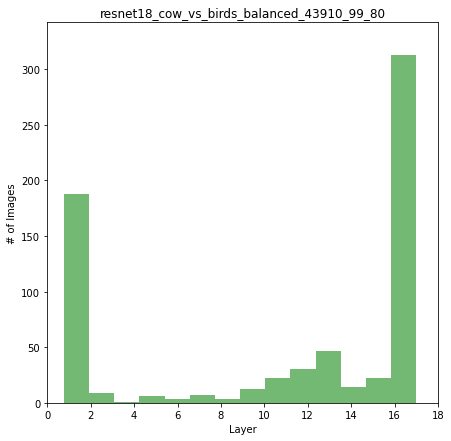

In [22]:
# plot PDs histogram
with open(os.path.join(save_dir,expt_name+'_testPDinfo.pkl'), 'rb') as handle:
    batch_info = pickle.load(handle)

batch_info['pd'] = np.array(batch_info['pd'])
batch_info['labels'] = np.array(batch_info['labels'])
batch_info['preds'] = np.array(batch_info['preds'])
correct_preds_arr = (batch_info['preds']==batch_info['labels'])


plt.figure(figsize=(7,7))
plt.title(expt_name)
plt.ylabel('# of Images')
plt.xlabel('Layer')
if model=='resnet18':
    plt.xlim((0,18))
elif model=='vgg16':
    plt.xlim((0,16))
# plt.ylim((0,80))
plt.hist(batch_info['pd'][correct_preds_arr ],bins=100,color='g',alpha=0.55)
# plt.hist(batch_info['pd'][~correct_preds_arr ],bins=100,color='r',alpha=0.55)
plt.savefig(os.path.join(save_dir,expt_name+'_PDplot.png'))

In [ ]:
batch_info['pred_probs']

# Viz some Image

In [ ]:
T1 = transforms.ToPILImage()
T2 = transforms.Resize((256,256))
# img = train_subset[100][0]
img = testset.data[100]
T2(T1((img)))

# GradCAM on Intermediate Layers

### Option-1

In [ ]:
# using grad_cam_forward pass

In [ ]:
# load checkpoint
expt_name = 'vgg16_mnist_patch_34272'
net = nn.DataParallel(VGG('VGG16',num_channels=1))
net.load_state_dict(torch.load(os.path.join(save_dir,f'{expt_name}.pt'))['net'])
net.eval()
layer_id1 = 3 # vgg layer to viz net.module.features[layer_id1]
               # 0,3,7,10,14,17,20,24,27,30,34,37,40
layer_id2 = 1 # info_dict['feats'][layer_id2]
              # 0,1,2,3,4,5,6,7,8,9,10,11,12
img_id = 19

In [ ]:
# add hook to layer you want to viz    
feature_maps = []  # This will be a list of Tensors, each representing a feature map
def hook_feat_map(mod, inp, out):
    out2 = torch.nn.functional.interpolate(out,(12,12))
    feature_maps.append(torch.reshape(out2, (out2.shape[0],-1)))
    
net.module.features[layer_id1].register_forward_hook(hook_feat_map)

In [ ]:
# get the nearest K neighbours
K = 29
lp_norm = 1
train_embs_pkl_path = os.path.join(save_dir,f'{expt_name}.pkl')

img = testset.data[img_id]
lab = testset.targets[img_id]

with torch.no_grad():
    # make img compatible for forward pass
    to_pil_trans = transforms.ToPILImage()
    if dataset=='mnist' or dataset=='kmnist' or dataset=='fmnist':
        img = to_pil_trans(img.to('cuda'))
    else:
        img = to_pil_trans(img.permute(2,0,1).to('cuda'))
    img = trans(img).unsqueeze(0)
    if img.shape[1]==4:
        img = img[:,0,:,:].unsqueeze(0)
        
    feature_maps = []
    out = torch.sigmoid(net(img))
    print(f'Model output: {out}')
    
    with open(train_embs_pkl_path, 'rb') as handle:            
        info_dict = pickle.load(handle)

        X_i = feature_maps[0].unsqueeze(1)  # (10000, 1, 784) test set
        X_j = info_dict['feats'][layer_id2].unsqueeze(0)  # (1, 60000, 784) train set
        if lp_norm==2:
            D_ij = ((X_i - X_j) ** 2).sum(-1)  # (10000, 60000) symbolic matrix of squared L2 distances
        elif lp_norm==1:
            D_ij = (abs(X_i - X_j)).sum(-1)  # (10000, 60000) symbolic matrix of squared L2 distances
        else:
            raise('Invalid lp_norm in arguments!')

        ind_knn = torch.topk(-D_ij,K,dim=1)  # Samples <-> Dataset, (N_test, K)
        lab_knn = info_dict['labels'][ind_knn[1]]  # (N_test, K) array of integers in [0,9]


    # free GPU memory
    del info_dict
    torch.cuda.empty_cache()

In [ ]:
nbr_inds = np.array(ind_knn[1][0].detach().cpu())
nbr_feats = X_j[0,nbr_inds,:].to('cuda')
nbr_labels = lab_knn.squeeze()
s = float(torch.median(-ind_knn[0]).detach().cpu()) # for the median trick


# pre-process the img to make it compatible for forward pass
to_pil_trans = transforms.ToPILImage()
if dataset=='mnist' or dataset=='kmnist' or dataset=='fmnist':
    img = to_pil_trans(img.squeeze().to('cuda'))
else:
    img = to_pil_trans(img.permute(2,0,1).to('cuda'))
img = trans(img).unsqueeze(0)
lab = int(lab)
if img.shape[1]==4:
    img = img[:,0,:,:].unsqueeze(0)
feature_maps = []
out, img_feat = net.module.gradcam_forward(img.to('cuda'),nbr_feats,nbr_labels,layer_id1,s)

# show intermediate gradcam
out.backward()

# pull the gradients out of the model
gradients = net.module.get_activations_gradient()

# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

# get the activations of the last convolutional layer
activations = img_feat.detach()

# weight the channels by corresponding gradients
for i in range(activations.shape[1]):
    activations[:, i, :, :] *= pooled_gradients[i]

# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze().detach().cpu()

# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = np.maximum(heatmap, 0)

# normalize the heatmap
heatmap /= (torch.max(heatmap)+1e-10)

# draw the heatmap
plt.matshow(heatmap.squeeze())

In [ ]:
T1 = torchvision.transforms.Compose([
        torchvision.transforms.Resize((256,256)),
        torchvision.transforms.ToTensor(),
#         torchvision.transforms.Lambda(center_crop()),
        torchvision.transforms.Lambda(lambda x: x.repeat(3,1,1)),
    ])
img = testset.data[img_id]
img = T1(to_pil_trans(img.squeeze()))
   
T2 = torchvision.transforms.Compose([
        torchvision.transforms.ToPILImage(),
        torchvision.transforms.Resize((256,256)),
        torchvision.transforms.ToTensor(),
#         torchvision.transforms.Lambda(center_crop()),
    ])
heatmap = T2(heatmap)

jet = cm.get_cmap('jet')
heatmap2 = jet(heatmap.squeeze())

img2 = torch.cat((img,1.0*torch.ones(256,256).unsqueeze(0)))
plt.figure(figsize=(10,10))
plt.imshow(1.0*img2.permute(1,2,0)+1.0*heatmap2)
# plt.imshow(1.2*img2.permute(1,2,0))

In [ ]:
# 0,3,7,10,14,17,20,24,27,30,34,37,40

### Option-2

In [ ]:
# visualizing the final output, but with different target layers

In [ ]:
# # load checkpoint
# img_id = 18
# img = testset.data[img_id]
# lab = testset.targets[img_id]
# expt_name = 'vgg16_kmnist_patch_48316'
# net = nn.DataParallel(VGG('VGG16',num_channels=1))
# net.load_state_dict(torch.load(os.path.join(save_dir,f'{expt_name}.pt'))['net'])
# net.eval()
# layer_id1 = -1 # vgg layer to viz net.module.features[layer_id1]
#                # 0,3,7,10,14,17,20,24,27,30,34,37,40
    


# # pre-process the img to make it compatible for forward pass
# to_pil_trans = transforms.ToPILImage()
# if dataset=='mnist' or dataset=='kmnist' or dataset=='fmnist':
#     img = to_pil_trans(img.squeeze().to('cuda'))
# else:
#     img = to_pil_trans(img.permute(2,0,1).to('cuda'))
# img = trans(img).unsqueeze(0)
# if img.shape[1]==4:
#     img = img[:,0,:,:].unsqueeze(0)
# feature_maps = []
# # out, img_feat = net.module.gradcam_forward(img.to('cuda'),nbr_feats,nbr_labels,layer_id1,s)
# out = net(img.to('cuda'))

# # compute grad cam masks
# targets = [ClassifierOutputTarget(0)]
# target_layers = [net.module.features[layer_id1]]

# # fetch Class Activation Maps (cams)
# cam = EigenCAM(model=net, target_layers=target_layers, use_cuda=True)
# grayscale_cams = cam(input_tensor=img, targets=targets, aug_smooth=True, eigen_smooth=True)

# # overlay cam on original images
# img = img.squeeze().unsqueeze(-1).detach().cpu().numpy()
# cam_op = show_cam_on_image(img, grayscale_cams[0]*0.5, use_rgb=True)
# img_list = []
# img_list.append(cam_op)

# # plot overlays
# plot_images(img_list,1,1)

In [ ]:
# user hyperparams
expt_name = 'vgg16_kmnist_patch_48316'
layer_id1 = 42

# load model
net = nn.DataParallel(VGG('VGG16',num_channels=1))
net.load_state_dict(torch.load(os.path.join(save_dir,f'{expt_name}.pt'))['net'])
net.eval()

# loop over test images
for _ in range(30):
    img_id = int(random.random()*len(testset.data))
    img = testset.data[img_id]
    
    # pre-process the img to make it compatible for forward pass
    to_pil_trans = transforms.ToPILImage()
    if dataset=='mnist' or dataset=='kmnist' or dataset=='fmnist':
        img_tensor = to_pil_trans(img.squeeze().to('cuda'))
    else:
        img_tensor = to_pil_trans(img.permute(2,0,1).to('cuda'))
    img_tensor = trans(img_tensor).unsqueeze(0)
    if img_tensor.shape[1]==4:
        img_tensor = img_tensor[:,0,:,:].unsqueeze(0)
        
    img_rgb = img_tensor.squeeze().unsqueeze(-1).expand(32,32,3)

    # gradCAM code
    targets = [ClassifierOutputTarget(0)]
    target_layers = [net.module.features[layer_id1]]

    cam = GradCAM(model=net, target_layers=target_layers, use_cuda=True)
    grayscale_cams = cam(input_tensor=img_tensor, targets=targets, aug_smooth=False, eigen_smooth=True)
    cam_op = show_cam_on_image(np.array(img_rgb), grayscale_cams[0], use_rgb=True)
    
    img_list = []
    img_list.append(img_rgb)
    img_list.append(grayscale_cams[0])
    img_list.append(cam_op)

    # plot results
    plot_images(img_list,rows=1,cols=3,titles=['Original Img','Heat Map','Overlay'])

### Option-3 SHAP (on final outputs)

In [ ]:
# user hyperparams
expt_name = 'vgg16_kmnist_27437'

# load model
net = nn.DataParallel(VGG('VGG16',num_channels=1))
net.load_state_dict(torch.load(os.path.join(save_dir,f'{expt_name}.pt'))['net'])
net.eval()

batch = next(iter(testloader))
images, _ = batch

shap_train_imgs = images[:10].to('cuda')
shap_test_imgs = images[10:14].to('cuda')

e = shap.DeepExplainer(net, shap_train_imgs)
shap_values = e.shap_values(shap_test_imgs)

shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(shap_test_imgs.cpu().numpy(), 1, -1), 1, 2)
shap.image_plot(shap_numpy, -test_numpy, width=100.0)

In [ ]:
net(shap_test_imgs).shape, len(shap_values), shap_values[0].shape

In [ ]:
for x in shap_train_imgs:
    print(x.unsqueeze(0).shape)

### Option-3 SHAP (on custom intermediate soft-KNN output)

In [ ]:
# user hyperparams
expt_name = 'vgg16_kmnist_27437'
layer_id = 0 # vgg layer to viz net.module.features[layer_id]
               # 0,3,7,10,14,17,20,24,27,30,34,37,40
train_emb_idx = 0 # info_dict['feats'][train_emb_idx]
              # 0,1,2,3,4,5,6,7,8,9,10,11,12

# load model
train_embs_pkl_path = os.path.join(save_dir,f'{expt_name}.pkl')
net = nn.DataParallel(customVGG2('VGG16', train_embs_pkl_path, layer_id, train_emb_idx, num_channels=1))
net.load_state_dict(torch.load(os.path.join(save_dir,f'{expt_name}.pt'))['net'])
net.eval()

# load batch of images
batch = next(iter(testloader))
images, _ = batch

# prepare shap train and test images
shap_train_imgs = images[:100].to('cuda')
shap_test_imgs = images[100:102].to('cuda')

e = shap.DeepExplainer(net, shap_train_imgs)
shap_values = e.shap_values(test_img)

shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_img.cpu().numpy(), 1, -1), 1, 2)
shap.image_plot(shap_numpy, -test_numpy, width=100.0)

### Option-4
Using grad-cam for intermediate layers as described in:
https://jacobgil.github.io/pytorch-gradcam-book/Pixel%20Attribution%20for%20embeddings.html

In [ ]:
# ===========user hyper-params==================
expt_name = 'vgg16_mnist_patch_34272'
net = nn.DataParallel(customVGG('VGG16',num_channels=1))
img_id = 5
layer_id1 = 0 # vgg layer to viz net.module.features[layer_id1]
               # 0,3,7,10,14,17,20,24,27,30,34,37,40
layer_id2 = 0 # info_dict['feats'][layer_id2]
              # 0,1,2,3,4,5,6,7,8,9,10,11,12
# =============================

In [ ]:
net.load_state_dict(torch.load(os.path.join(save_dir,f'{expt_name}.pt'))['net'])
net.eval()
# add hook to layer you want to viz    
feature_maps = []  # This will be a list of Tensors, each representing a feature map
def hook_feat_map(mod, inp, out):
    out2 = torch.nn.functional.interpolate(out,(12,12))
    feature_maps.append(torch.reshape(out2, (out2.shape[0],-1)))
    
net.module.features[layer_id1].register_forward_hook(hook_feat_map)

# get the nearest K neighbours
K = 29
lp_norm = 1
train_embs_pkl_path = os.path.join(save_dir,f'{expt_name}.pkl')

img = testset.data[img_id]
lab = testset.targets[img_id]

with torch.no_grad():
    # make img compatible for forward pass
    to_pil_trans = transforms.ToPILImage()
    if dataset=='mnist' or dataset=='kmnist' or dataset=='fmnist':
        img = to_pil_trans(img.to('cuda'))
    else:
        img = to_pil_trans(img.permute(2,0,1).to('cuda'))
    img = trans(img).unsqueeze(0)
    if img.shape[1]==4:
        img = img[:,0,:,:].unsqueeze(0)
        
    feature_maps = []
    out = torch.sigmoid(net.module.simpleForward(img.to('cuda')))
    print(f'Model output: {out}')
    
    with open(train_embs_pkl_path, 'rb') as handle:            
        info_dict = pickle.load(handle)

        X_i = feature_maps[0].unsqueeze(1)  # (10000, 1, 784) test set
        X_j = info_dict['feats'][layer_id2].unsqueeze(0)  # (1, 60000, 784) train set
        if lp_norm==2:
            D_ij = ((X_i - X_j) ** 2).sum(-1)  # (10000, 60000) symbolic matrix of squared L2 distances
        elif lp_norm==1:
            D_ij = (abs(X_i - X_j)).sum(-1)  # (10000, 60000) symbolic matrix of squared L2 distances
        else:
            raise('Invalid lp_norm in arguments!')

        ind_knn = torch.topk(-D_ij,K,dim=1)  # Samples <-> Dataset, (N_test, K)
        lab_knn = info_dict['labels'][ind_knn[1]]  # (N_test, K) array of integers in [0,9]


    # free GPU memory
    del info_dict
    torch.cuda.empty_cache()

In [ ]:
nbr_inds = np.array(ind_knn[1][0].detach().cpu())
nbr_feats = X_j[0,nbr_inds,:].to('cuda')
nbr_labels = lab_knn.squeeze()
s = float(torch.median(-ind_knn[0]).detach().cpu()) # for the median trick

net.module.nbr_feats = nbr_feats
net.module.nbr_labels = nbr_labels
net.module.s = s
net.module.layer_id = layer_id1

In [ ]:
# pre-process the img to make it compatible for forward pass
to_pil_trans = transforms.ToPILImage()
if dataset=='mnist' or dataset=='kmnist' or dataset=='fmnist':
    img = to_pil_trans(img.squeeze().to('cuda'))
else:
    img = to_pil_trans(img.permute(2,0,1).to('cuda'))
img = trans(img).unsqueeze(0)
if img.shape[1]==4:
    img = img[:,0,:,:].unsqueeze(0)

# compute grad cam masks
targets = [ClassifierOutputTarget(0)]
target_layers = [net.module.features[layer_id1]]

# fetch Class Activation Maps (cams)
cam = GradCAMPlusPlus(model=net, target_layers=target_layers, use_cuda=True)
grayscale_cams = cam(input_tensor=img, targets=targets, aug_smooth=False, eigen_smooth=True)

# overlay cam on original images
img = img.squeeze().unsqueeze(-1).detach().cpu().numpy()
cam_op = show_cam_on_image(img, grayscale_cams[0], use_rgb=True)
img_list = []
img_list.append(img)
img_list.append(grayscale_cams[0])
img_list.append(cam_op)

# plot overlays
plot_images(img_list,rows=1,cols=3)

In [ ]:
# code in loop
expt_name = 'vgg16_mnist_patch_34272'
net = nn.DataParallel(customVGG('VGG16',num_channels=1))
net.load_state_dict(torch.load(os.path.join(save_dir,f'{expt_name}.pt'))['net'])
net.eval()
for _ in range(1000):
    # ===========user hyper-params==================
    img_id = int(random.random()*len(testset.data))
    layer_id1 = 40 # vgg layer to viz net.module.features[layer_id1]
                   # 0,3,7,10,14,17,20,24,27,30,34,37,40
    layer_id2 = 12 # info_dict['feats'][layer_id2]
                  # 0,1,2,3,4,5,6,7,8,9,10,11,12
    # =============================
    # add hook to layer you want to viz    
    feature_maps = []  # This will be a list of Tensors, each representing a feature map
def hook_feat_map(mod, inp, out):
    out2 = torch.nn.functional.interpolate(out,(12,12))
    feature_maps.append(torch.reshape(out2, (out2.shape[0],-1)))

    net.module.features[layer_id1].register_forward_hook(hook_feat_map)

    # get the nearest K neighbours
    K = 29
    lp_norm = 1
    train_embs_pkl_path = os.path.join(save_dir,f'{expt_name}.pkl')

    img = testset.data[img_id]
    lab = testset.targets[img_id]

    with torch.no_grad():
        # make img compatible for forward pass
        to_pil_trans = transforms.ToPILImage()
        if dataset=='mnist' or dataset=='kmnist' or dataset=='fmnist':
            img = to_pil_trans(img.to('cuda'))
        else:
            img = to_pil_trans(img.permute(2,0,1).to('cuda'))
        img = trans(img).unsqueeze(0)
        if img.shape[1]==4:
            img = img[:,0,:,:].unsqueeze(0)

        feature_maps = []
        out = torch.sigmoid(net.module.simpleForward(img.to('cuda')))
        print(f'Model output: {out}')

        with open(train_embs_pkl_path, 'rb') as handle:            
            info_dict = pickle.load(handle)

            X_i = feature_maps[0].unsqueeze(1)  # (10000, 1, 784) test set
            X_j = info_dict['feats'][layer_id2].unsqueeze(0)  # (1, 60000, 784) train set
            if lp_norm==2:
                D_ij = ((X_i - X_j) ** 2).sum(-1)  # (10000, 60000) symbolic matrix of squared L2 distances
            elif lp_norm==1:
                D_ij = (abs(X_i - X_j)).sum(-1)  # (10000, 60000) symbolic matrix of squared L2 distances
            else:
                raise('Invalid lp_norm in arguments!')

            ind_knn = torch.topk(-D_ij,K,dim=1)  # Samples <-> Dataset, (N_test, K)
            lab_knn = info_dict['labels'][ind_knn[1]]  # (N_test, K) array of integers in [0,9]


        # free GPU memory
        del info_dict
        torch.cuda.empty_cache()

    nbr_inds = np.array(ind_knn[1][0].detach().cpu())
    nbr_feats = X_j[0,nbr_inds,:].to('cuda')
    nbr_labels = lab_knn.squeeze()
    s = float(torch.median(-ind_knn[0]).detach().cpu()) # for the median trick

    net.module.nbr_feats = nbr_feats
    net.module.nbr_labels = nbr_labels
    net.module.s = s
    net.module.layer_id = layer_id1

    # pre-process the img to make it compatible for forward pass
    to_pil_trans = transforms.ToPILImage()
    if dataset=='mnist' or dataset=='kmnist' or dataset=='fmnist':
        img = to_pil_trans(img.squeeze().to('cuda'))
    else:
        img = to_pil_trans(img.permute(2,0,1).to('cuda'))
    img = trans(img).unsqueeze(0)
    if img.shape[1]==4:
        img = img[:,0,:,:].unsqueeze(0)

    # compute grad cam masks
    targets = [ClassifierOutputTarget(0)]
    target_layers = [net.module.features[layer_id1]]

    # fetch Class Activation Maps (cams)
    cam = GradCAMPlusPlus(model=net, target_layers=target_layers, use_cuda=True)
    grayscale_cams = cam(input_tensor=img, targets=targets, aug_smooth=False, eigen_smooth=True)

    # overlay cam on original images
    img = img.squeeze().unsqueeze(-1).detach().cpu().numpy()
    cam_op = show_cam_on_image(img, grayscale_cams[0], use_rgb=True)
    img_list = []
    img_list.append(img)
    img_list.append(grayscale_cams[0])
    img_list.append(cam_op)

    # plot overlays
    plot_images(img_list,rows=1,cols=3,titles=['Original Img','Heat Map','Overlay'])

# Re-Train Only Initial Layers on Randomized Labels

In [ ]:
# user hyperparams
expt_name = 'vgg16_kmnist_patch_48316'
num_ch = 1

In [ ]:
net = nn.DataParallel(VGG('VGG16',num_channels=num_ch))
net.load_state_dict(torch.load(os.path.join(save_dir,f'{expt_name}.pt'))['net'])
for i in range(10,45,1):
    for param in net.module.features[i].parameters():
        param.requires_grad = False
for param in net.module.classifier.parameters():
        param.requires_grad = False

In [ ]:
# sanity checking if all gradients false except initial layers
for param in net.module.parameters():
    print(param.requires_grad)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
net = net.to(device)
    
if device == 'cuda':
    cudnn.benchmark = True


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)


# Training
def train(epoch, randomize_labels=False):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(tqdm(trainloader)):
        if randomize_labels:
            targets = targets[torch.randperm(targets.shape[0])] # randomize labels
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    print(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                 % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))


def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(tqdm(testloader)):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    print(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                 % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))


In [ ]:
train(2,randomize_labels=True)
test(2)
scheduler.step()

print('Saving..')
state = {
    'net': net.state_dict(),
    'epoch': 2,
}
#         if not os.path.isdir(f'{args['expt_name']}_checkpoint'):
#             os.mkdir('checkpoint')
torch.save(state, os.path.join(save_dir,f'{expt_name}_a.pt'))

# Re-Train Only Final Layers on True Labels

In [ ]:
# freeze initial layers
for param in net.parameters():
    param.requires_grad = True

for i in range(0,10,1):
    for param in net.module.features[i].parameters():
        param.requires_grad = False

In [ ]:
# sanity checking if all gradients false except initial layers
for param in net.module.parameters():
    print(param.requires_grad)

In [ ]:
epoch = 3
train(epoch,randomize_labels=False)
test(epoch)
scheduler.step()

print('Saving..')
state = {
    'net': net.state_dict(),
    'epoch': epoch,
}
#         if not os.path.isdir(f'{args['expt_name']}_checkpoint'):
#             os.mkdir('checkpoint')
torch.save(state, os.path.join(save_dir,f'{expt_name}_b.pt'))

# Misc

In [ ]:
expt_name = 'vgg16_mnist_75872'

In [ ]:
# plot PDs histogram

with open(os.path.join(save_dir,expt_name+'_testPDinfo.pkl'), 'rb') as handle:
    batch_info = pickle.load(handle)

batch_info['pd'] = np.array(batch_info['pd'])
batch_info['labels'] = np.array(batch_info['labels'])
batch_info['preds'] = np.array(batch_info['preds'])
correct_preds_arr = (batch_info['preds']==batch_info['labels'])


plt.figure(figsize=(7,7))
plt.title('MNIST', fontsize=25)
plt.ylabel('No. of Images', fontsize=25)
plt.xlabel('VGG16 Layers', fontsize=25)
if model=='resnet18':
    plt.xlim((0,18))
elif model=='vgg16':
    plt.xlim((0,16))
plt.ylim((0,80))
plt.hist(batch_info['pd'][correct_preds_arr ],bins=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16],color='g',alpha=0.55)
plt.hist(batch_info['pd'][~correct_preds_arr ],bins=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16],color='r',alpha=0.55)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.savefig(os.path.join(save_dir,expt_name+'_PDplot.png'))

In [ ]:
expt_name = 'vgg16_fmnist_88507'

In [ ]:
# plot PDs histogram

with open(os.path.join(save_dir,expt_name+'_testPDinfo.pkl'), 'rb') as handle:
    batch_info = pickle.load(handle)

batch_info['pd'] = np.array(batch_info['pd'])
batch_info['labels'] = np.array(batch_info['labels'])
batch_info['preds'] = np.array(batch_info['preds'])
correct_preds_arr = (batch_info['preds']==batch_info['labels'])


plt.figure(figsize=(7,7))
plt.title('FMNIST', fontsize=25)
plt.ylabel('No. of Images', fontsize=25)
plt.xlabel('VGG16 Layers', fontsize=25)
if model=='resnet18':
    plt.xlim((0,18))
elif model=='vgg16':
    plt.xlim((0,16))
plt.ylim((0,80))
plt.hist(batch_info['pd'][correct_preds_arr ],bins=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16],color='g',alpha=0.55)
plt.hist(batch_info['pd'][~correct_preds_arr ],bins=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16],color='r',alpha=0.55)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.savefig(os.path.join(save_dir,expt_name+'_PDplot.png'))

In [ ]:
expt_name = 'vgg16_cifar10_18394'

In [ ]:
# plot PDs histogram

with open(os.path.join(save_dir,expt_name+'_testPDinfo.pkl'), 'rb') as handle:
    batch_info = pickle.load(handle)

batch_info['pd'] = np.array(batch_info['pd'])
batch_info['labels'] = np.array(batch_info['labels'])
batch_info['preds'] = np.array(batch_info['preds'])
correct_preds_arr = (batch_info['preds']==batch_info['labels'])


plt.figure(figsize=(7,7))
plt.title('CIFAR10', fontsize=25)
plt.ylabel('No. of Images', fontsize=25)
plt.xlabel('VGG16 Layers', fontsize=25)
if model=='resnet18':
    plt.xlim((0,18))
elif model=='vgg16':
    plt.xlim((0,16))
plt.ylim((0,80))
plt.hist(batch_info['pd'],bins=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16],color='g',alpha=0.55)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.savefig(os.path.join(save_dir,expt_name+'_PDplot.png'))

In [ ]:
expt_name = 'vgg16_kmnist_27437'

In [ ]:
# plot PDs histogram

with open(os.path.join(save_dir,expt_name+'_testPDinfo.pkl'), 'rb') as handle:
    batch_info = pickle.load(handle)

batch_info['pd'] = np.array(batch_info['pd'])
batch_info['labels'] = np.array(batch_info['labels'])
batch_info['preds'] = np.array(batch_info['preds'])
correct_preds_arr = (batch_info['preds']==batch_info['labels'])


plt.figure(figsize=(7,7))
plt.title('KMNIST w/o patch', fontsize=25)
plt.ylabel('No. of Images', fontsize=25)
plt.xlabel('VGG16 Layers', fontsize=25)
if model=='resnet18':
    plt.xlim((0,18))
elif model=='vgg16':
    plt.xlim((0,16))
plt.ylim((0,80))
plt.hist(batch_info['pd'][correct_preds_arr ],bins=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16],color='g',alpha=0.55)
plt.hist(batch_info['pd'][~correct_preds_arr ],bins=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16],color='r',alpha=0.55)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.savefig(os.path.join(save_dir,expt_name+'_PDplot.png'))

In [ ]:
212023/7977